# Ford GoBike Bike Sharing Analysis

Ford GoBike is the Bay Area's bike share system. Bay Area Bike Share was introduced in 2013 as a pilot program for the region, with 700 bikes and 70 stations across San Francisco and San Jose. Once expansion is complete, Ford GoBike will grow to 7,000 bikes across San Francisco, the East Bay and San Jose. 

In this research, we intended to answer the following big questions: 
1. Which timing of the following rides is busiest during the days, months and hours? 
2. How does the duration trip trend look like? 
3. Is there any particular effect of the operational area? 
4. Whether subscriber have different trend than normal customer from 2017-2018?

## Preliminary Data Wrangling
### Downloading the data

In [1]:
import pandas as pd
import numpy as np
import requests
from requests import get
from zipfile import ZipFile
import os
from os import path, getcwd, listdir 
from io import BytesIO
import json
import calendar
import seaborn as sb
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
%matplotlib inline

In [2]:
folder_name = 'fordgobike'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [3]:
pd.read_csv('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv').to_csv('{}/2017-forgobike-tripdata.csv'.format(folder_name))
for month in range(1,13):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2018' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
    unzipped_file = ZipFile(BytesIO(response.content))
    unzipped_file.extractall(folder_name)

In [4]:
list_csv = []
for file_name in listdir(folder_name):
    list_csv.append(pd.read_csv(folder_name+'/'+file_name))
df = pd.concat(list_csv)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [5]:
df.to_csv('master_data.csv')
df = pd.read_csv('master_data.csv')

C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.head()

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
0,0,0.0,96,NaN,80110,43.0,37.778768,-122.415929,San Francisco Public Library (Grove St at Hyde...,2018-01-01 15:12:50.2450,1987.0,Male,74.0,37.776435,-122.426244,Laguna St at Hayes St,2017-12-31 16:57:39.6540,Customer
1,1,1.0,88,NaN,78800,96.0,37.766210,-122.426614,Dolores St at 15th St,2018-01-01 13:49:55.6170,1965.0,Female,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2017-12-31 15:56:34.8420,Customer
2,2,2.0,1094,NaN,45768,245.0,37.870348,-122.267764,Downtown Berkeley BART,2018-01-01 11:28:36.8830,NaN,NaN,245.0,37.870348,-122.267764,Downtown Berkeley BART,2017-12-31 22:45:48.4110,Customer
3,3,3.0,2831,NaN,62172,5.0,37.783899,-122.408445,Powell St BART Station (Market St at 5th St),2018-01-01 10:47:23.5310,NaN,NaN,60.0,37.774520,-122.409449,8th St at Ringold St,2017-12-31 17:31:10.6360,Customer
4,4,4.0,3167,NaN,43603,247.0,37.867789,-122.265896,Fulton St at Bancroft Way,2018-01-01 02:29:57.5710,1997.0,Female,239.0,37.868813,-122.258764,Bancroft Way at Telegraph Ave,2017-12-31 14:23:14.0010,Subscriber


### Checking the datatype and creating age column

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2383421 entries, 0 to 2383420
Data columns (total 18 columns):
Unnamed: 0                 int64
Unnamed: 0.1               float64
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   object
member_birth_year          float64
member_gender              object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 object
user_type                  object
dtypes: float64(8), int64(3), object(7)
memory usage: 327.3+ MB


So after downloading the data and made the csv, we found some of the datatype problems:
1. unnamed column (?) 
2. duration_sec from int64 to float64 
3. bike_id, end_station_id, start_station_id from int64 & float64 to string 
4. end_time and start_time from object to datetime 
5. member birth year from float into int 

In [8]:
df['duration_sec'] = df['duration_sec'].apply(float)
df['bike_id'] = df['bike_id'].apply(str)
df['end_station_id'] = df['end_station_id'].apply(float)
df['start_station_id'] = df['start_station_id'].apply(float)
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_time'] = pd.to_datetime(df['start_time'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2383421 entries, 0 to 2383420
Data columns (total 18 columns):
Unnamed: 0                 int64
Unnamed: 0.1               float64
bike_id                    object
bike_share_for_all_trip    object
duration_sec               float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          float64
member_gender              object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
dtypes: datetime64[ns](2), float64(9), int64(1), object(6)
memory usage: 327.3+ MB


In [10]:
df.head()

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
0,0,0.0,96,NaN,80110.0,43.0,37.778768,-122.415929,San Francisco Public Library (Grove St at Hyde...,2018-01-01 15:12:50.245,1987.0,Male,74.0,37.776435,-122.426244,Laguna St at Hayes St,2017-12-31 16:57:39.654,Customer
1,1,1.0,88,NaN,78800.0,96.0,37.766210,-122.426614,Dolores St at 15th St,2018-01-01 13:49:55.617,1965.0,Female,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2017-12-31 15:56:34.842,Customer
2,2,2.0,1094,NaN,45768.0,245.0,37.870348,-122.267764,Downtown Berkeley BART,2018-01-01 11:28:36.883,NaN,NaN,245.0,37.870348,-122.267764,Downtown Berkeley BART,2017-12-31 22:45:48.411,Customer
3,3,3.0,2831,NaN,62172.0,5.0,37.783899,-122.408445,Powell St BART Station (Market St at 5th St),2018-01-01 10:47:23.531,NaN,NaN,60.0,37.774520,-122.409449,8th St at Ringold St,2017-12-31 17:31:10.636,Customer
4,4,4.0,3167,NaN,43603.0,247.0,37.867789,-122.265896,Fulton St at Bancroft Way,2018-01-01 02:29:57.571,1997.0,Female,239.0,37.868813,-122.258764,Bancroft Way at Telegraph Ave,2017-12-31 14:23:14.001,Subscriber


Let's make a new column for member birth year for the convinience of the analysis. The column will be the age of the members directly instead of their birth year

In [11]:
df['age'] = 2018-df['member_birth_year']

In [12]:
df['age'].isnull().value_counts()

False    2206162
True      177259
Name: age, dtype: int64

In [13]:
df['age'].describe()

count    2.206162e+06
mean     3.546318e+01
std      1.051346e+01
min      1.800000e+01
25%      2.800000e+01
50%      3.300000e+01
75%      4.100000e+01
max      1.370000e+02
Name: age, dtype: float64

We found out that there are some of the age data that are completely impossible such as the maximum value is 137 years old, there is a need to recheck this age column dataset

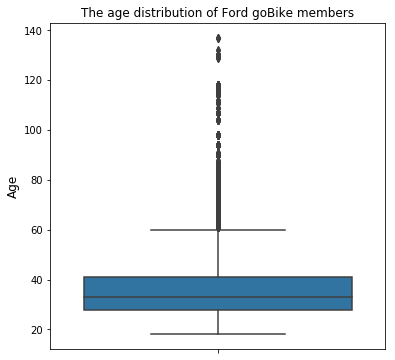

In [14]:
plt.figure(figsize=(6,6))
base_color = sb.color_palette()[0]
sb.boxplot(data = df, y = 'age', color = base_color)
plt.title('The age distribution of Ford goBike members', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.savefig('The age distribution of Ford goBike members.png')

By the boxplot, we can determine that the outlier lies beyond 60 years old, so we will be discarding those with outlier values (above 60 and null value) 

In [15]:
df1 = df.query('(age <= 60) & (age == age)')

In [16]:
df1.age.isnull().value_counts()

False    2156049
Name: age, dtype: int64

In [17]:
df1.age.describe()

count    2.156049e+06
mean     3.471873e+01
std      9.290393e+00
min      1.800000e+01
25%      2.800000e+01
50%      3.300000e+01
75%      4.000000e+01
max      6.000000e+01
Name: age, dtype: float64

Now we can see that the dataset impossible values have been removed

In [18]:
df1['age'] = df1['age'].apply(int)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Creating area column 
Now we will add another variable called area in order for us to know the trends of the operational areas of Ford GoBike: San Fransico, East Bay and San Jose

In [19]:
df1.start_station_longitude.describe()

count    2.156049e+06
mean    -1.223515e+02
std      1.583654e-01
min     -1.224737e+02
25%     -1.224116e+02
50%     -1.223974e+02
75%     -1.222914e+02
max     -7.357000e+01
Name: start_station_longitude, dtype: float64

After doing some checking with the age column, we just sample through some of the start station longitude and found out that there are impossible data values with the start station longitude for the max as well

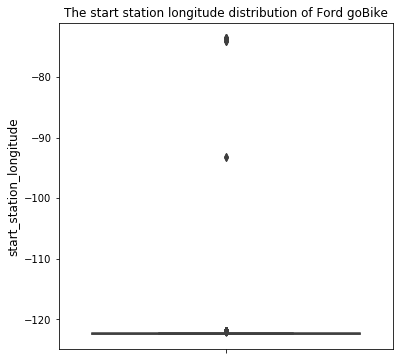

In [20]:
plt.figure(figsize=(6,6))
base_color = sb.color_palette()[0]
sb.boxplot(data = df, y = 'start_station_longitude', color = base_color)
plt.title('The start station longitude distribution of Ford goBike', fontsize=12)
plt.ylabel('start_station_longitude', fontsize=12)
plt.savefig('The start station longitude distribution of Ford goBike.png')

Now after seeing the boxplot, we would make a new column which categorized the trips into their respective areas by setting the threshold for each areas by referencing to their stations and finding their latitude and longitude through google maps. We also would revise the threshold we got from the goggle maps below

#### latitude longitude notes (Furthest station)  
#### San Fransisco 
- min latitude: 37.722702, -122.446286 (Balboa Park) 
- max latitude: 37.799692, -122.396470 (The Embarcadero)
- min longitude: 37.722702, -122.446286 (Balboa Park) 
- max longitude: 37.742508, -122.387408 (Evans ave)

#### East Bay (Oakland)
- min latitude: 37.782897, -122.220277 (Foothill Blvd) 
- max latitude: 37.880090, -122.270495 (Vine St) 
- min longitude: 37.839542, -122.298648 (2100 Powell St) 
- max longitude: 37.782897, -122.220277 (Foothill Blvd)

#### San Jose 
- min latitude: 37.309301, -121.893948 (Bird Ave) 
- max latitude: 37.368621, -121.917525 (Metro Dr) 
- min longitude: 37.368621, -121.917525 (Metro Dr)
- max longitude: 37.280258, -121.834908 (South San Jose)


#### Conclusion 
1. San Fransisco: (37.722702 - 37.799692) (-122.446286 - -122.387408)
2. East Bay     : (37.782897 - 37.880090) (-122.298648 - -122.220277) 
3. San Jose     : (37.280258 - 37.368621) (-121.917525 - -121.834908)

In [21]:
def area_df(df1):

    if (((37.722702 <= df1.end_station_latitude <= 37.799692) & (37.722702 <= df1.start_station_latitude <= 37.799692)) & ((-122.446286 <= df1.end_station_longitude <= -122.387408) & (-122.446286 <= df1.start_station_longitude <= -122.387408))):
        return 'SF'
    elif (((37.782897 <= df1.end_station_latitude <= 37.880090) & (37.782897 <= df1.start_station_latitude <= 37.880090)) & ((-122.298648 <= df1.end_station_longitude <= -122.220277) & (-122.298648 <= df1.start_station_longitude <= -122.220277))):
        return 'EB'
    elif (((37.280258 <= df1.end_station_latitude <= 37.368621) & (37.280258 <= df1.start_station_latitude <= 37.368621)) & ((-121.917525 <= df1.end_station_longitude <= -121.834908) & (-121.917525 <= df1.start_station_longitude <= -121.834908))):
        return 'SJ'
    else:
        return np.nan

In [22]:
df2 = df1.copy()
df2['area'] = df2.apply(area_df, axis = 1)

In [23]:
df2['area'].value_counts()

SF    1493182
EB     434556
SJ      96907
Name: area, dtype: int64

In [24]:
dfnan = df2.query('area != area')
dfnan

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
6,6,6.0,3539,NaN,4507.0,259.0,37.866249,-122.299371,Addison St at Fourth St,2018-01-01 01:04:35.619,1991.0,Female,259.0,37.866249,-122.299371,Addison St at Fourth St,2017-12-31 23:49:28.422,Customer,27,NaN
33,33,33.0,3539,NaN,781.0,259.0,37.866249,-122.299371,Addison St at Fourth St,2017-12-31 23:46:54.972,1991.0,Female,251.0,37.870555,-122.279720,California St at University Ave,2017-12-31 23:33:52.981,Customer,27,NaN
52,52,52.0,2966,NaN,707.0,259.0,37.866249,-122.299371,Addison St at Fourth St,2017-12-31 23:25:55.455,1994.0,Male,245.0,37.870348,-122.267764,Downtown Berkeley BART,2017-12-31 23:14:07.542,Customer,24,NaN
189,189,189.0,2985,NaN,1711.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:54.700,1992.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:23.684,Subscriber,26,NaN
190,190,190.0,2736,NaN,1208.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:51.551,1994.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:56:43.394,Subscriber,24,NaN
191,191,191.0,3398,NaN,1699.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:47.224,1993.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:28.104,Subscriber,25,NaN
192,192,192.0,3496,NaN,1697.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:40.608,1993.0,Female,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:23.404,Subscriber,25,NaN
294,294,294.0,2456,NaN,528.0,16.0,37.794130,-122.394430,Steuart St at Market St,2017-12-31 18:13:40.127,1994.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 18:04:51.785,Customer,24,NaN
310,310,310.0,2456,NaN,1596.0,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 18:01:49.197,1994.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 17:35:13.180,Customer,24,NaN
332,332,332.0,1518,NaN,285.0,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2017-12-31 17:47:17.839,1982.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 17:42:32.477,Subscriber,36,NaN


We found out that there are more than 131k entries that did not get included into the coordinates above, we would update the latitiude and longitude accordingly 

In [25]:
dfnan['end_station_latitude'].value_counts().sort_values

<bound method Series.sort_values of 37.804770    41127
37.799953    12501
37.794130     5854
37.795392     5436
37.410000     4551
37.400000     4443
37.866249     3936
37.880222     2852
37.776598     2493
37.789756     2397
37.792251     2136
37.794130     2077
37.802746     1941
37.775880     1622
37.787168     1297
37.791464     1186
37.778742     1109
37.775232     1103
37.420000     1046
37.795001     1006
37.791300      975
37.786375      954
37.780526      930
37.797280      926
37.870407      876
37.776639      852
37.789625      839
37.783899      828
37.789677      825
37.798014      809
             ...  
37.823321        2
37.731727        2
44.950000        2
37.764765        2
37.808848        2
37.838800        2
37.838127        2
37.754436        2
37.770030        2
37.809013        1
37.833558        1
37.797673        1
37.830545        1
37.450000        1
37.807239        1
37.844493        1
37.352601        1
37.806970        1
37.835788        1
37.730168     

In [26]:
dfnan['end_station_latitude'].value_counts().sort_index()

37.263310      11
37.320000       1
37.327581       5
37.329732       2
37.330000      16
37.330165       5
37.333798       1
37.340000      23
37.350000      15
37.352601       1
37.360000      12
37.370000      22
37.380000     391
37.390000     785
37.400000    4443
37.410000    4551
37.420000    1046
37.430000      28
37.440000       3
37.450000       1
37.490000       3
37.730168       1
37.731727       2
37.738572       6
37.739853     100
37.742314       7
37.743684       5
37.744067      19
37.745739       2
37.747300      18
             ... 
37.866043      50
37.866249     177
37.866249    3936
37.866418      16
37.867789      97
37.867789       4
37.868813      91
37.869060      10
37.869060     577
37.869060      45
37.869360      52
37.869967      26
37.870139     283
37.870348     532
37.870407     876
37.870555     126
37.871719     255
37.872355     100
37.873558     323
37.873676     100
37.873748      36
37.873792     201
37.874014     437
37.874014      15
37.875112 

In [27]:
dfnan['end_station_longitude'].value_counts().sort_index()

-122.473658     202
-122.453704     803
-122.447291      73
-122.446546     323
-122.444293     125
-122.441838      43
-122.439446     144
-122.439078      91
-122.437777      53
-122.436943      17
-122.436861      14
-122.435650      71
-122.434559     124
-122.433950      12
-122.433812      28
-122.433708      38
-122.432642      23
-122.431946      32
-122.431804      14
-122.431158     108
-122.431060      49
-122.430675      24
-122.429558      43
-122.429156       5
-122.429156      22
-122.427411       2
-122.427411       3
-122.427317      94
-122.426829       4
-122.426826     150
               ... 
-122.224498    1076
-122.222603     394
-122.217728     218
-122.213037     145
-122.000000       1
-121.990000       1
-121.980000      33
-121.970000      69
-121.960000    1752
-121.950000    1479
-121.940000    3989
-121.930000    2768
-121.920000    1149
-121.910000      37
-121.905733       1
-121.901782       2
-121.900000      30
-121.890000      19
-121.886943       1


In [28]:
dfnan['end_station_longitude'].value_counts().sort_values

<bound method Series.sort_values of -122.403234    31087
-122.398525    12501
-122.403234    10040
-122.394430     7931
-122.394203     5436
-121.940000     3989
-122.299371     3936
-122.269592     2852
-121.930000     2768
-122.397086     2136
-122.413579     1941
-122.395282     1911
-121.960000     1752
-122.394643     1731
-122.393170     1622
-121.950000     1479
-122.388098     1297
-122.391034     1186
-121.920000     1149
-122.392741     1109
-122.224498     1076
-122.399970     1006
-122.399051      975
-122.404904      954
-122.390288      930
-122.398436      926
-122.299676      876
-122.395526      852
-122.400811      839
-122.408445      828
               ...  
-122.422140        2
-122.411726        2
-122.272080        2
-121.830000        2
-122.275733        2
-93.220000         2
-122.261351        1
-122.280192        1
-122.262409        1
-122.405216        1
-122.261823        1
-122.398963        1
-122.266588        1
-122.266447        1
-122.254337        

In [29]:
dfnan.query('end_station_latitude == 37.794130')

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
520112,412,NaN,2248,No,583.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 20:02:26.487,1984.0,Female,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-01-31 19:52:43.151,Subscriber,34,NaN
520356,656,NaN,1318,No,357.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 19:07:24.479,1965.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-01-31 19:01:27.262,Subscriber,53,NaN
520457,757,NaN,2854,No,444.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 18:51:02.834,1989.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-01-31 18:43:38.656,Subscriber,29,NaN
520885,1185,NaN,3497,No,313.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 17:56:35.132,1963.0,Female,8.0,37.799953,-122.398525,The Embarcadero at Vallejo St,2018-01-31 17:51:21.655,Subscriber,55,NaN
520913,1213,NaN,3661,No,467.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 17:53:47.955,1985.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-01-31 17:46:00.727,Subscriber,33,NaN
521132,1432,NaN,2822,No,379.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 17:30:53.680,1971.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-01-31 17:24:34.398,Subscriber,47,NaN
521219,1519,NaN,3223,No,345.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 17:23:19.498,1972.0,Female,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-01-31 17:17:33.695,Subscriber,46,NaN
521279,1579,NaN,2605,No,355.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 17:17:21.042,1971.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-01-31 17:11:25.800,Subscriber,47,NaN
521371,1671,NaN,2050,No,295.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 17:08:54.072,1967.0,Male,8.0,37.799953,-122.398525,The Embarcadero at Vallejo St,2018-01-31 17:03:58.729,Subscriber,51,NaN
521432,1732,NaN,1039,No,198.0,16.0,37.79413,-122.39443,Steuart St at Market St,2018-01-31 16:59:11.724,1974.0,Male,8.0,37.799953,-122.398525,The Embarcadero at Vallejo St,2018-01-31 16:55:53.411,Subscriber,44,NaN


In [30]:
dfnan.query('end_station_latitude == 37.804770')

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
189,189,189.0,2985,NaN,1711.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:54.700,1992.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:23.684,Subscriber,26,NaN
190,190,190.0,2736,NaN,1208.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:51.551,1994.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:56:43.394,Subscriber,24,NaN
191,191,191.0,3398,NaN,1699.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:47.224,1993.0,Male,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:28.104,Subscriber,25,NaN
192,192,192.0,3496,NaN,1697.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 20:16:40.608,1993.0,Female,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2017-12-31 19:48:23.404,Subscriber,25,NaN
310,310,310.0,2456,NaN,1596.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 18:01:49.197,1994.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 17:35:13.180,Customer,24,NaN
367,367,367.0,3047,NaN,794.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 17:28:23.372,1994.0,Male,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2017-12-31 17:15:08.680,Customer,24,NaN
386,386,386.0,1019,NaN,546.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 17:19:10.064,1965.0,Male,23.0,37.791464,-122.391034,The Embarcadero at Steuart St,2017-12-31 17:10:03.681,Subscriber,53,NaN
442,442,442.0,2831,NaN,2391.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 16:44:03.289,1988.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2017-12-31 16:04:11.514,Subscriber,30,NaN
535,535,535.0,629,NaN,2006.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 16:01:45.546,1963.0,Male,10.0,37.795393,-122.404770,Washington St at Kearny St,2017-12-31 15:28:19.416,Customer,55,NaN
536,536,536.0,1832,NaN,2046.0,6.0,37.80477,-122.403234,The Embarcadero at Sansome St,2017-12-31 16:01:43.540,1998.0,Male,10.0,37.795393,-122.404770,Washington St at Kearny St,2017-12-31 15:27:37.015,Customer,20,NaN


In [31]:
dfnan.query('end_station_longitude == -122.473658')

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
1657265,119179,NaN,3798,No,387.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 18:46:52.081,1994.0,Female,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 18:40:24.340,Customer,24,NaN
1657309,119223,NaN,3664,No,10042.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 18:38:33.455,1994.0,Male,323.0,37.798014,-122.405950,Broadway at Kearny,2018-08-12 15:51:10.487,Subscriber,24,NaN
1657312,119226,NaN,4029,No,10080.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 18:38:24.669,1992.0,Male,323.0,37.798014,-122.405950,Broadway at Kearny,2018-08-12 15:50:24.226,Customer,26,NaN
1657596,119510,NaN,1379,No,2256.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 17:40:30.630,1992.0,Female,29.0,37.782405,-122.439446,O'Farrell St at Divisadero St,2018-08-12 17:02:53.656,Customer,26,NaN
1657597,119511,NaN,2784,No,1898.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 17:40:21.943,1991.0,Male,29.0,37.782405,-122.439446,O'Farrell St at Divisadero St,2018-08-12 17:08:43.264,Customer,27,NaN
1657738,119652,NaN,3388,No,1178.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 17:14:23.418,1964.0,Male,71.0,37.773063,-122.439078,Broderick St at Oak St,2018-08-12 16:54:44.844,Subscriber,54,NaN
1657997,119911,NaN,3034,No,897.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 16:31:43.401,1984.0,Male,70.0,37.773311,-122.444293,Central Ave at Fell St,2018-08-12 16:16:46.365,Subscriber,34,NaN
1657998,119912,NaN,3186,No,912.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 16:31:21.529,1985.0,Female,70.0,37.773311,-122.444293,Central Ave at Fell St,2018-08-12 16:16:08.610,Subscriber,33,NaN
1658009,119923,NaN,506,No,1652.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 16:30:04.490,1989.0,Female,52.0,37.777416,-122.441838,McAllister St at Baker St,2018-08-12 16:02:32.112,Customer,29,NaN
1658220,120134,NaN,3798,Yes,1709.0,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 15:53:37.133,1962.0,Other,367.0,37.771104,-122.473658,Outside Lands 2018 (Temporary Station),2018-08-12 15:25:08.021,Subscriber,56,NaN


We also find out that there are temporary stations

In [32]:
dfnan.query('end_station_latitude == 37.263310')

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
1778512,48264,NaN,2598,No,963.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 15:15:31.666,1982.0,Male,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 14:59:28.243,Customer,36,NaN
1778950,48702,NaN,3615,No,3647.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 14:02:34.280,1982.0,Male,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 13:01:46.815,Customer,36,NaN
1779004,48756,NaN,2258,No,3010.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 13:53:52.326,1967.0,Female,316.0,37.330165,-121.885831,San Salvador St at 1st St,2018-09-23 13:03:41.452,Subscriber,51,NaN
1779164,48916,NaN,1753,No,5725.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 13:26:03.132,1971.0,Male,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 11:50:37.660,Customer,47,NaN
1779207,48959,NaN,1517,No,1349.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 13:18:55.175,1973.0,Male,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 12:56:25.589,Customer,45,NaN
1779266,49018,NaN,406,No,2074.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 13:10:46.906,1989.0,Female,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 12:36:12.257,Customer,29,NaN
1779319,49071,NaN,1855,No,4179.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 12:57:27.321,1990.0,Female,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 11:47:47.613,Customer,28,NaN
1779324,49076,NaN,2434,No,4107.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 12:56:56.884,1990.0,Male,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 11:48:29.657,Customer,28,NaN
1779524,49276,NaN,572,No,1477.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 12:11:16.771,1986.0,Male,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 11:46:39.387,Customer,32,NaN
1779651,49403,NaN,2434,No,1513.0,374.0,37.26331,-121.833332,Viva Calle SJ,2018-09-23 11:48:05.424,1959.0,Male,374.0,37.263310,-121.833332,Viva Calle SJ,2018-09-23 11:22:52.392,Customer,59,NaN


#### Revision 
After the trial and errors, we manage to find all of the necessary latitude and longitude (both max and min) and revise the adjusted minimum and maximum of both latitude and longitude  
####  San Fransisco: (37.722702 - 37.799692) (-122.446286 - -122.387408)
- 37.771104, -122.473658 Outside Lands 2018 (Temporary Station)
- 37.80477, -122.403234 (The embarcadero)
- 37.771917, -122.453704 (Fell St)
- 37.739853, -122.385655	(Mendell St at Fairfax Ave)
####  East Bay: (37.782897 - 37.880090) (-122.298648 - -122.220277) 
- 37.866249, -122.299371 (Addison St at Fourth St)
- 37.880222, -122.269592 (Vine St at Shattuck Ave)
- 37.775232, -122.224498 (Fruitvale BART Station)
- 37.870407, -122.299676 (Fifth St at Delaware St)
- 37.779930, -122.217728 (Foothill Blvd at Harrington Ave)
- 37.775745, -122.213037	(Foothill Blvd at 42nd Ave)
####  San Jose: (37.280258 - 37.368621) (-121.917525 - -121.834908)
- 37.263310, -121.833332 (viva calle sj) 
- 37.810743	-122.291415	14th St at Mandela Pkwy

#### Conclusion 
1. San Fransisco: (37.722702 - 37.80477) (-122.453705 - -122.385654)
2. East Bay     : (37.775232 - 37.880223) (-122.299676 - -122.213036) 
3. San Jose     : (37.263310 - 37.368621) (-121.917525 - -121.833332)

In [33]:
def area_df2(df1):
    
    if (((37.722702 <= df1.end_station_latitude <= 37.80477) & (37.722702 <= df1.start_station_latitude <= 37.80477)) & ((-122.453705 <= df1.end_station_longitude <= -122.385654) & (-122.453705 <= df1.start_station_longitude <= -122.385654))):
        return 'SF'
    elif (((37.775232 <= df1.end_station_latitude <= 37.880223) & (37.775232 <= df1.start_station_latitude <= 37.880223)) & ((-122.299676 <= df1.end_station_longitude <= -122.213036) & (-122.299676 <= df1.start_station_longitude <= -122.213036))):
        return 'EB'
    elif (((37.263310 <= df1.end_station_latitude <= 37.368621) & (37.263310 <= df1.start_station_latitude <= 37.368621)) & ((-121.917525 <= df1.end_station_longitude <= -121.833332) & (-121.917525 <= df1.start_station_longitude <= -121.833332))):
        return 'SJ'
    elif ((df1.end_station_name == 'Outside Lands 2018 (Temporary Station)') | (df1.start_station_name == 'Outside Lands 2018 (Temporary Station)')):
        return 'Temp'
    else:
        return np.nan

In [34]:
df2['area'] = df2.apply(area_df2, axis = 1)

In [35]:
df2['area'].value_counts()

SF      1596468
EB       450891
SJ        96929
Temp        315
Name: area, dtype: int64

In [36]:
df3 = df2.dropna(subset=['end_station_name', 'start_station_name'])

In [37]:
dfnan = df3.query('area != area')
dfnan

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
124544,124544,124544.0,1230,NaN,2037.0,4.0,37.785881,-122.408915,Cyril Magnin St at Ellis St,2017-11-17 15:56:51.165,1969.0,Male,209.0,37.833558,-122.267418,45th St at MLK Jr Way,2017-11-17 15:22:53.773,Subscriber,49,NaN
185190,185190,185190.0,1210,NaN,5471.0,312.0,37.329732,-121.901782,San Jose Diridon Station,2017-10-31 09:28:29.835,1976.0,Male,195.0,37.812314,-122.260779,Bay Pl at Vernon St,2017-10-31 07:57:18.251,Subscriber,42,NaN
192832,192832,192832.0,450,NaN,2278.0,209.0,37.833558,-122.267418,45th St at MLK Jr Way,2017-10-28 15:45:36.831,1969.0,Male,41.0,37.781270,-122.418740,Golden Gate Ave at Polk St,2017-10-28 15:07:37.864,Subscriber,49,NaN
193555,193555,193555.0,1050,NaN,13305.0,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2017-10-28 12:30:39.791,1978.0,Male,183.0,37.808702,-122.269927,Telegraph Ave at 19th St,2017-10-28 08:48:53.981,Customer,40,NaN
194062,194062,194062.0,1356,NaN,3331.0,16.0,37.794130,-122.394430,Steuart St at Market St,2017-10-28 09:36:12.432,1982.0,Female,183.0,37.808702,-122.269927,Telegraph Ave at 19th St,2017-10-28 08:40:40.892,Subscriber,36,NaN
194092,194092,194092.0,652,NaN,2308.0,41.0,37.781270,-122.418740,Golden Gate Ave at Polk St,2017-10-28 09:04:40.314,1969.0,Male,209.0,37.833558,-122.267418,45th St at MLK Jr Way,2017-10-28 08:26:11.382,Subscriber,49,NaN
195522,195522,195522.0,2123,NaN,4241.0,178.0,37.819381,-122.261928,Broadway at 30th St,2017-10-27 17:31:12.351,1983.0,Male,81.0,37.775880,-122.393170,Berry St at 4th St,2017-10-27 16:20:31.340,Subscriber,35,NaN
255087,255087,255087.0,2961,NaN,2579.0,22.0,37.789756,-122.394643,Howard St at Beale St,2017-10-11 08:39:36.012,1985.0,Male,185.0,37.801858,-122.265368,Jackson St at 14th St,2017-10-11 07:56:36.340,Subscriber,33,NaN
263649,263649,263649.0,3027,NaN,16338.0,197.0,37.808848,-122.249680,El Embarcadero at Grand Ave,2017-10-08 18:08:45.021,1983.0,Female,71.0,37.773063,-122.439078,Broderick St at Oak St,2017-10-08 13:36:26.861,Customer,35,NaN
275559,275559,275559.0,1581,NaN,4496.0,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2017-10-05 08:29:11.084,1983.0,Female,221.0,37.794353,-122.253875,12th St at 6th Ave,2017-10-05 07:14:14.303,Subscriber,35,NaN


In [38]:
dfnan['start_station_latitude'].value_counts().sort_values

<bound method Series.sort_values of 37.829705    7
37.801858    7
37.810743    5
37.807239    4
37.795392    3
37.869360    3
37.797673    3
37.812314    3
37.808750    3
37.812331    3
37.800002    2
37.808702    2
37.833558    2
37.783899    2
37.804562    2
37.795393    2
37.795195    2
37.830545    2
37.823847    2
37.809824    2
37.781270    2
37.783757    2
37.808848    2
37.774814    2
37.869060    2
37.794130    1
37.773063    1
37.778742    1
37.800516    1
37.776754    1
37.798014    1
37.866043    1
37.791464    1
37.869060    1
37.792251    1
37.776619    1
37.831275    1
37.783521    1
37.759200    1
37.868813    1
37.775880    1
37.797320    1
37.827757    1
37.789756    1
37.827757    1
37.855956    1
37.781074    1
37.794353    1
37.787492    1
Name: start_station_latitude, dtype: int64>

There are some of the latitude and longitude that have nan value; however, due to their low numbers of 95 entries, we can just drop them 

In [39]:
df3 = df3.dropna(subset=['area'])

In [40]:
df3 

,Unnamed: 0,Unnamed: 0.1,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,area
0,0,0.0,96,NaN,80110.0,43.0,37.778768,-122.415929,San Francisco Public Library (Grove St at Hyde...,2018-01-01 15:12:50.245,1987.0,Male,74.0,37.776435,-122.426244,Laguna St at Hayes St,2017-12-31 16:57:39.654,Customer,31,SF
1,1,1.0,88,NaN,78800.0,96.0,37.766210,-122.426614,Dolores St at 15th St,2018-01-01 13:49:55.617,1965.0,Female,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2017-12-31 15:56:34.842,Customer,53,SF
4,4,4.0,3167,NaN,43603.0,247.0,37.867789,-122.265896,Fulton St at Bancroft Way,2018-01-01 02:29:57.571,1997.0,Female,239.0,37.868813,-122.258764,Bancroft Way at Telegraph Ave,2017-12-31 14:23:14.001,Subscriber,21,EB
6,6,6.0,3539,NaN,4507.0,259.0,37.866249,-122.299371,Addison St at Fourth St,2018-01-01 01:04:35.619,1991.0,Female,259.0,37.866249,-122.299371,Addison St at Fourth St,2017-12-31 23:49:28.422,Customer,27,EB
12,12,12.0,2311,NaN,2183.0,24.0,37.789677,-122.390428,Spear St at Folsom St,2018-01-01 00:29:18.743,1990.0,Male,67.0,37.776639,-122.395526,San Francisco Caltrain Station 2 (Townsend St...,2017-12-31 23:52:55.581,Subscriber,28,SF
13,13,13.0,3717,NaN,2170.0,24.0,37.789677,-122.390428,Spear St at Folsom St,2018-01-01 00:29:06.924,1990.0,Male,67.0,37.776639,-122.395526,San Francisco Caltrain Station 2 (Townsend St...,2017-12-31 23:52:55.937,Subscriber,28,SF
15,15,15.0,558,NaN,1544.0,27.0,37.788059,-122.391865,Beale St at Harrison St,2018-01-01 00:19:23.047,1980.0,Female,14.0,37.795001,-122.399970,Clay St at Battery St,2017-12-31 23:53:38.943,Subscriber,38,SF
16,16,16.0,3646,NaN,1474.0,27.0,37.788059,-122.391865,Beale St at Harrison St,2018-01-01 00:19:14.351,1979.0,Male,14.0,37.795001,-122.399970,Clay St at Battery St,2017-12-31 23:54:40.146,Subscriber,39,SF
18,18,18.0,3114,NaN,1532.0,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-01-01 00:18:21.953,1988.0,Other,78.0,37.773717,-122.411647,Folsom St at 9th St,2017-12-31 23:52:49.497,Subscriber,30,SF
19,19,19.0,1473,NaN,1216.0,123.0,37.760594,-122.414817,Folsom St at 19th St,2018-01-01 00:06:50.058,1971.0,Male,4.0,37.785881,-122.408915,Cyril Magnin St at Ellis St,2017-12-31 23:46:33.993,Subscriber,47,SF


In [41]:
df3.describe()

,Unnamed: 0,Unnamed: 0.1,duration_sec,end_station_id,end_station_latitude,end_station_longitude,member_birth_year,start_station_id,start_station_latitude,start_station_longitude,age
count,2.144559e+06,439709.000000,2.144559e+06,2.144559e+06,2.144559e+06,2.144559e+06,2.144559e+06,2.144559e+06,2.144559e+06,2.144559e+06,2.144559e+06
mean,1.179002e+05,254947.811193,7.840271e+02,1.133761e+02,3.776942e+01,-1.223533e+02,1.983259e+03,1.152334e+02,3.776931e+01,-1.223539e+02,3.474060e+01
std,1.075014e+05,149004.322739,2.074304e+03,9.751266e+01,9.828864e-02,1.159862e-01,9.293181e+00,9.768745e+01,9.843333e-02,1.165747e-01,9.293181e+00
min,0.000000e+00,0.000000,6.100000e+01,3.000000e+00,3.726331e+01,-1.224737e+02,1.958000e+03,3.000000e+00,3.726331e+01,-1.224737e+02,1.800000e+01
25%,4.539450e+04,125837.000000,3.490000e+02,3.000000e+01,3.777166e+01,-1.224099e+02,1.978000e+03,3.000000e+01,3.777106e+01,-1.224116e+02,2.800000e+01
50%,9.050200e+04,253022.000000,5.450000e+02,8.100000e+01,3.778127e+01,-1.223971e+02,1.985000e+03,8.400000e+01,3.778127e+01,-1.223974e+02,3.300000e+01
75%,1.506330e+05,381902.000000,8.380000e+02,1.810000e+02,3.779539e+01,-1.222948e+02,1.990000e+03,1.810000e+02,3.779539e+01,-1.222948e+02,4.000000e+01
max,5.196990e+05,519699.000000,8.628100e+04,3.810000e+02,3.788022e+01,-1.218333e+02,2.000000e+03,3.810000e+02,3.788022e+01,-1.218333e+02,6.000000e+01


#### Creating column for the hourly, monthly and weekdays 

In [42]:
df3['start_time_date']=df3['start_time'].dt.date
df3['end_time_date']=df3['end_time'].dt.date

In [43]:
df3['start_time_year_month']=df3['start_time'].map(lambda x: x.strftime('%Y-%m'))
df3['end_time_year_month']=df3['end_time'].map(lambda x: x.strftime('%Y-%m'))

In [44]:
df3['start_time_hour_minute']=df3['start_time'].map(lambda x: x.strftime('%H-%m'))
df3['end_time_hour_minute']=df3['end_time'].map(lambda x: x.strftime('%H-%m'))

In [45]:
df3['start_time_hour']=df3['start_time'].dt.hour
df3['end_time_hour']=df3['end_time'].dt.hour

In [46]:
df3['start_time_weekday']=df3['start_time'].dt.weekday_name
df3['end_time_weekday']=df3['end_time'].dt.weekday_name

In [47]:
df3['start_time_weekday_abbr']=df3['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df3['end_time_weekday_abbr']=df3['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [48]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2144559 entries, 0 to 2383419
Data columns (total 32 columns):
Unnamed: 0                 int64
Unnamed: 0.1               float64
bike_id                    object
bike_share_for_all_trip    object
duration_sec               float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          float64
member_gender              object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
area                       object
start_time_date            object
end_time_date              object
start_time_year_month      object
end_time_year_month        object
start_time_hour_minute     object
end_time_hour_

In [49]:
df['start_station_name'].value_counts()

San Francisco Ferry Building (Harry Bridges Plaza)                 53648
San Francisco Caltrain Station 2  (Townsend St at 4th St)          49672
San Francisco Caltrain (Townsend St at 4th St)                     47638
The Embarcadero at Sansome St                                      47054
Market St at 10th St                                               46878
Berry St at 4th St                                                 44672
Montgomery St BART Station (Market St at 2nd St)                   43465
Powell St BART Station (Market St at 4th St)                       41798
Steuart St at Market St                                            37714
Howard St at Beale St                                              36461
Powell St BART Station (Market St at 5th St)                       32994
Embarcadero BART Station (Beale St at Market St)                   29532
3rd St at Townsend St                                              28063
Townsend St at 7th St                              

In [50]:
df4 = df3.drop(['Unnamed: 0', 'Unnamed: 0.1', 'end_station_latitude', 'end_station_longitude', 'member_birth_year', 'start_station_latitude', 'start_station_longitude'], axis=1)

#### Filtering based on the Trip Duration

In [51]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2144559 entries, 0 to 2383419
Data columns (total 25 columns):
bike_id                    object
bike_share_for_all_trip    object
duration_sec               float64
end_station_id             float64
end_station_name           object
end_time                   datetime64[ns]
member_gender              object
start_station_id           float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
area                       object
start_time_date            object
end_time_date              object
start_time_year_month      object
end_time_year_month        object
start_time_hour_minute     object
end_time_hour_minute       object
start_time_hour            int64
end_time_hour              int64
start_time_weekday         object
end_time_weekday           object
start_time_weekday_abbr    object
end_time_weekday_abbr      object
dtypes: datetime64[ns

In [52]:
df4['duration_min'] = df4['duration_sec']/60 

Text(0,0.5,'duration_min')

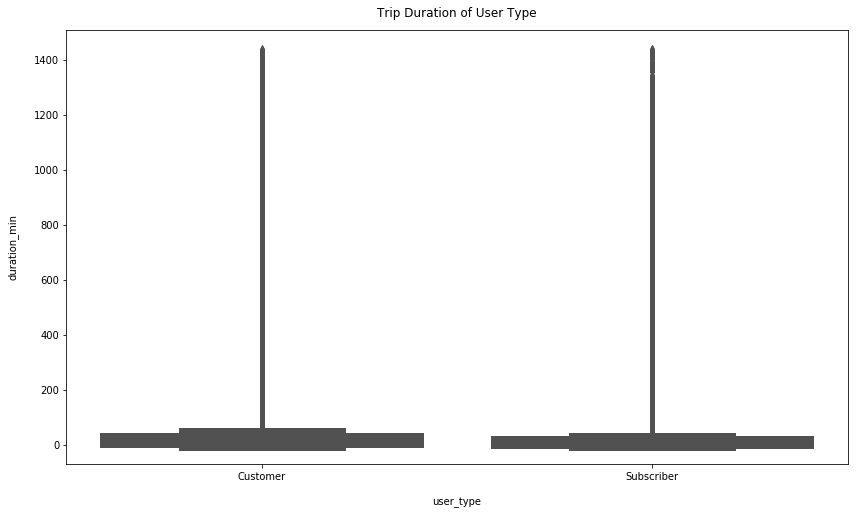

In [53]:
plt.figure(figsize=(14,8))
my_palette = {'Subscriber':'#3498db', 'Customer':'#e74c3c'}
ax = sb.boxplot(x='user_type', y='duration_min', linewidth=11, palette=my_palette, data= df4)
plt.title('Trip Duration of User Type', y=1.015)
plt.xlabel('user_type', labelpad=16)
plt.ylabel('duration_min', labelpad=16)

We found out that the company policy only allowed maximum borrowing time 45 minutes with additional 15 minutes for extra charge of $3 for each additional 15 minutes. So we will create a threshold of 60 minutes for trip duration

In [54]:
len(df4.query('duration_min >= 61'))

23485

In [55]:
df5 = df4.query('duration_min <= 60')

In [56]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120617 entries, 12 to 2383419
Data columns (total 26 columns):
bike_id                    object
bike_share_for_all_trip    object
duration_sec               float64
end_station_id             float64
end_station_name           object
end_time                   datetime64[ns]
member_gender              object
start_station_id           float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
area                       object
start_time_date            object
end_time_date              object
start_time_year_month      object
end_time_year_month        object
start_time_hour_minute     object
end_time_hour_minute       object
start_time_hour            int64
end_time_hour              int64
start_time_weekday         object
end_time_weekday           object
start_time_weekday_abbr    object
end_time_weekday_abbr      object
duration_min        

Text(0,0.5,'duration_min')

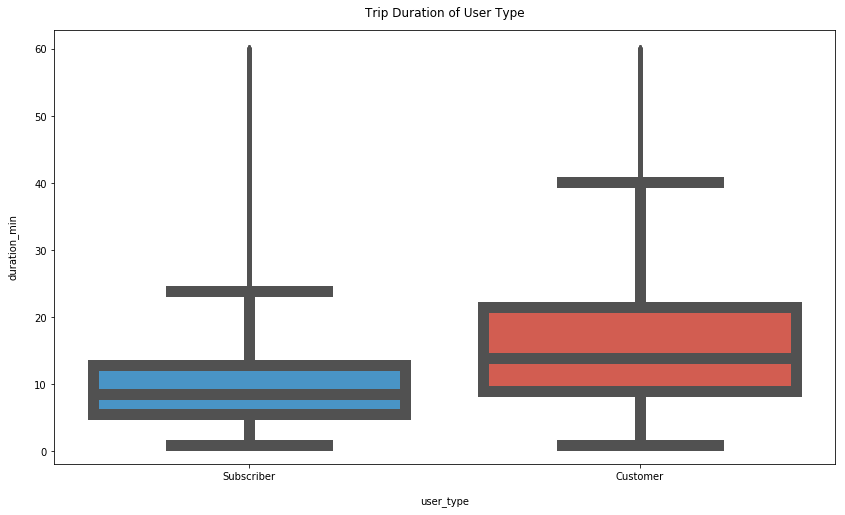

In [57]:
plt.figure(figsize=(14,8))
my_palette = {'Subscriber':'#3498db', 'Customer':'#e74c3c'}
ax = sb.boxplot(x='user_type', y='duration_min', linewidth=11, palette=my_palette, data= df5)
plt.title('Trip Duration of User Type', y=1.015)
plt.xlabel('user_type', labelpad=16)
plt.ylabel('duration_min', labelpad=16)

## Exploratory Data Analysis 
### Univariate 

Text(0.5,0,'Duration(min)')

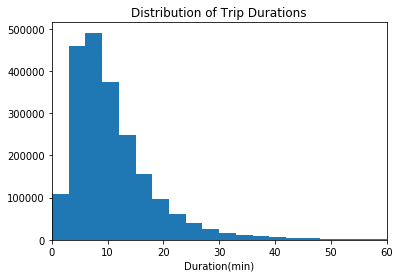

In [58]:
bins = np.arange(0, df5['duration_min'].max() + 5 , 3)
plt.hist(data = df5 , x = 'duration_min' , bins = bins)
plt.xlim(0,60)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration(min)')

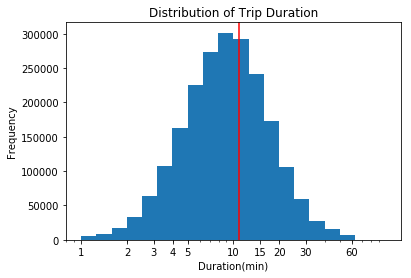

In [59]:
bins = 10**np.arange(0 , 2+0.1 , 0.1)
ticks =  [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df5 , x = 'duration_min' , bins = bins);
plt.xlabel('Duration(min)')
plt.xscale('log')
plt.xticks(ticks,labels)
plt.title('Distribution of Trip Duration')
plt.ylabel('Frequency')
plt.axvline(x=df5['duration_min'].mean(), color='red')

In [60]:
df5['duration_min'].mean()

10.882000568702884

On average, the trip duration lasted 10.8 minutes for each trip 

In [61]:
df_sf = df5.query('area == "SF"')

In [62]:
df_eb = df5.query('area == "EB"')

In [63]:
df_sj = df5.query('area == "SJ"')

In [64]:
df_temp = df5.query('area == "Temp"')

In [65]:
df_sf['start_station_name'].value_counts().sort_values(ascending=False).nlargest(10)

San Francisco Caltrain Station 2  (Townsend St at 4th St)    46334
San Francisco Caltrain (Townsend St at 4th St)               43949
Market St at 10th St                                         43416
San Francisco Ferry Building (Harry Bridges Plaza)           41969
Berry St at 4th St                                           41449
Montgomery St BART Station (Market St at 2nd St)             39186
The Embarcadero at Sansome St                                35342
Powell St BART Station (Market St at 4th St)                 35270
Howard St at Beale St                                        34286
Steuart St at Market St                                      33841
Name: start_station_name, dtype: int64

In [66]:
df_eb['start_station_name'].value_counts().sort_values(ascending=False).nlargest(10)

19th Street BART Station         20754
Bancroft Way at College Ave      16127
MacArthur BART Station           15682
Lake Merritt BART Station        12058
Bancroft Way at Telegraph Ave    11815
Grand Ave at Perkins St          11033
Bay Pl at Vernon St              10974
Frank H Ogawa Plaza              10393
2nd Ave at E 18th St             10222
El Embarcadero at Grand Ave      10019
Name: start_station_name, dtype: int64

In [67]:
df_sj['start_station_name'].value_counts().sort_values(ascending=False).nlargest(10)

San Fernando St at 4th St         8275
San Jose Diridon Station          7623
5th St at Virginia St             7555
Ryland Park                       5592
San Salvador St at 9th St         4684
Julian St at The Alameda          3848
Paseo De San Antonio at 2nd St    3502
San Fernando at 7th St            3405
The Alameda at Bush St            3377
San Jose City Hall                3043
Name: start_station_name, dtype: int64

In [144]:
ym_df = df5.groupby(['start_time_year_month']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
ym_df

,start_time_year_month,count
0,2017-06,2238
1,2017-07,33861
2,2017-08,66589
3,2017-09,81995
4,2017-10,91582
5,2017-11,82953
6,2017-12,75132
7,2018-01,83572
8,2018-02,94996
9,2018-03,98848


Text(0,0.5,'Frequency')

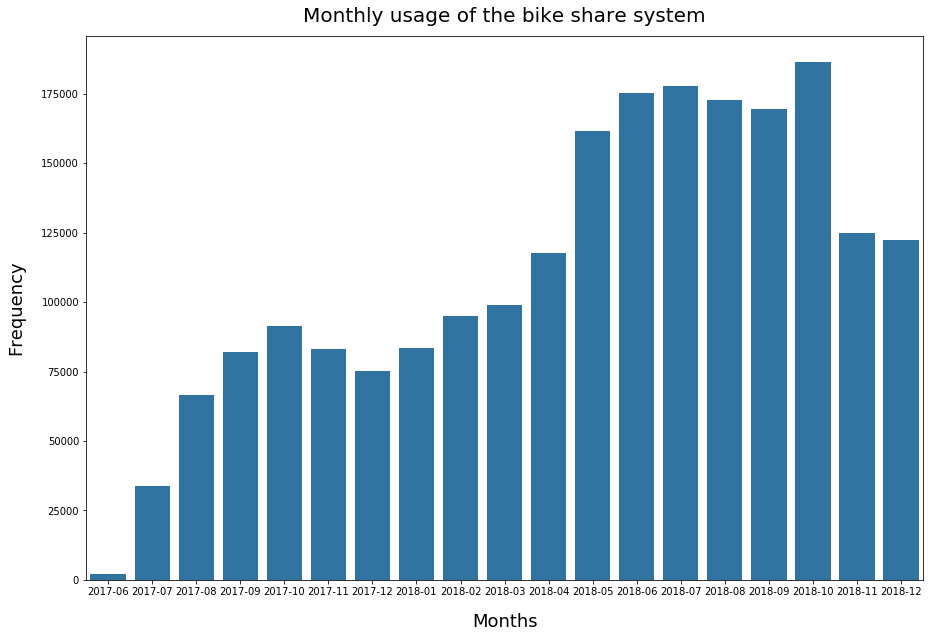

In [146]:
plt.figure(figsize=(15,10))
sb.barplot(data=ym_df, x='start_time_year_month', y='count', color = base_color)
plt.title("Monthly usage of the bike share system", fontsize=20, y=1.015)
plt.xlabel('Months', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)

We can see that there is some significant trends rising with the lowest from june 2017 and the highest is october 2018. There are some down trends from their previous months for each years Novembers and Decembers.

In [152]:
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
days_df = df5.groupby(['start_time_weekday_abbr']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
days_df

,start_time_weekday_abbr,count
0,Fri,333618
1,Mon,341861
2,Sat,181030
3,Sun,159247
4,Thu,363386
5,Tue,371968
6,Wed,369507


Text(0,0.5,'Frequency')

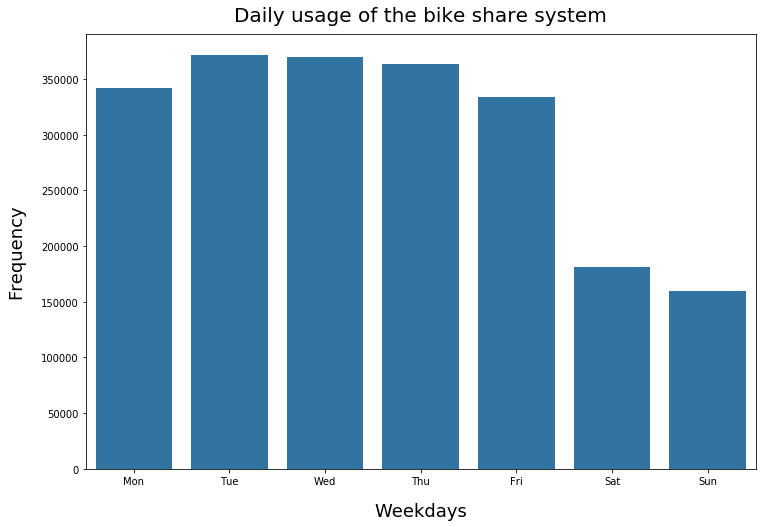

In [156]:
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(12,8))
sb.barplot(data=days_df, x='start_time_weekday_abbr', y='count', color = base_color, order= weekday)
plt.title("Daily usage of the bike share system", fontsize=20, y=1.015)
plt.xlabel('Weekdays', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)

With weekends trend as lower rather than usual weekdays, we might see that the reason is that there are less people go outside or using other means of transportation for the weekends. 

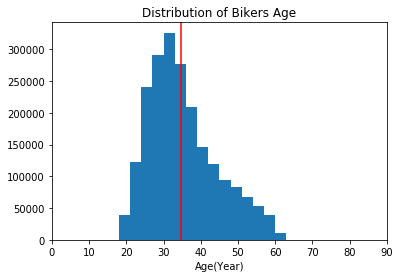

In [70]:
bins = np.arange(0, df5['age'].max() + 5 , 3)
plt.hist(data = df5 , x = 'age' , bins = bins)
plt.xlim(0,90)
plt.title('Distribution of Bikers Age')
plt.xlabel('Age(Year)')
plt.axvline(x=df5['age'].mean(), color='red')

In [71]:
df5['age'].mean()

34.74368638938573

The mean of the users age is 34 years old. Since there is no other usage for the age yet, we wil not use this for more detailed graph combination

In [157]:
hour_df = df5.groupby(['start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
hour_df

,start_time_hour,count
0,0,11149
1,1,6124
2,2,3721
3,3,2061
4,4,2744
5,5,10690
6,6,41202
7,7,120428
8,8,248800
9,9,190609


Text(0,0.5,'Frequency')

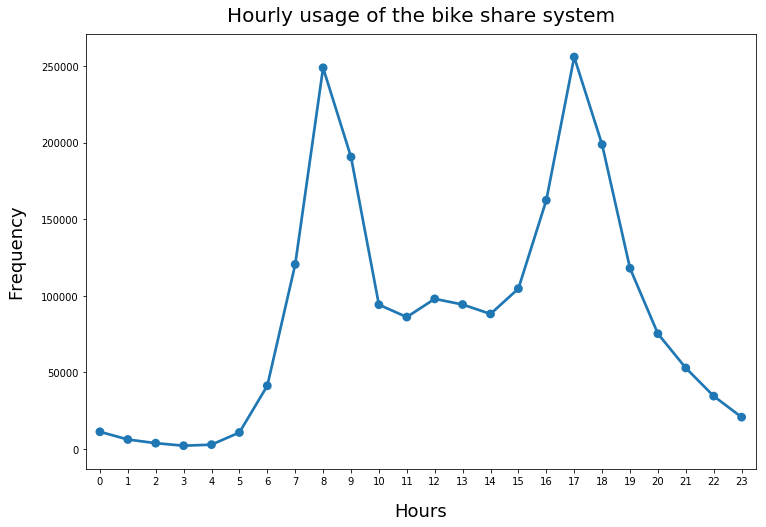

In [161]:
plt.figure(figsize=(12,8))
sb.pointplot(data=hour_df, x='start_time_hour', y='count', color = base_color)
plt.title("Hourly usage of the bike share system", fontsize=20, y=1.015)
plt.xlabel('Hours', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)

We can see that there is a trend with the heaviest traffic with 8 am and 5 pm as people go to work and go back to their home from their work around that time 

In [160]:
area_df = df5.groupby(['area']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
area_df

,area,count
0,EB,445832
1,SF,1578523
2,SJ,95983
3,Temp,279


Text(0,0.5,'Frequency')

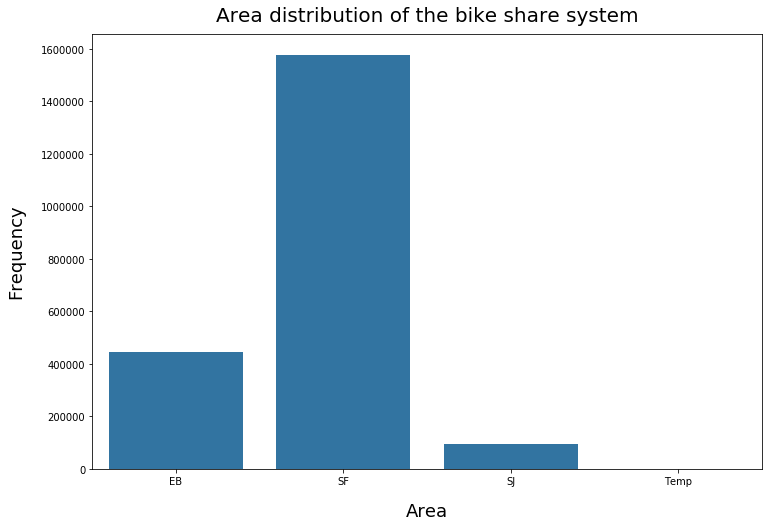

In [162]:
plt.figure(figsize=(12,8))
sb.barplot(data=area_df, x='area', y='count', color = base_color)
plt.title("Area distribution of the bike share system", fontsize=20, y=1.015)
plt.xlabel('Area', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)

We can see that there is a massive usage in the San Fransisco area compared to other areas, we will compare this data with other and more detailed graph

In [163]:
user_df = df5.groupby(['user_type']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
user_df

,user_type,count
0,Customer,230369
1,Subscriber,1890248


Text(0,0.5,'Frequency')

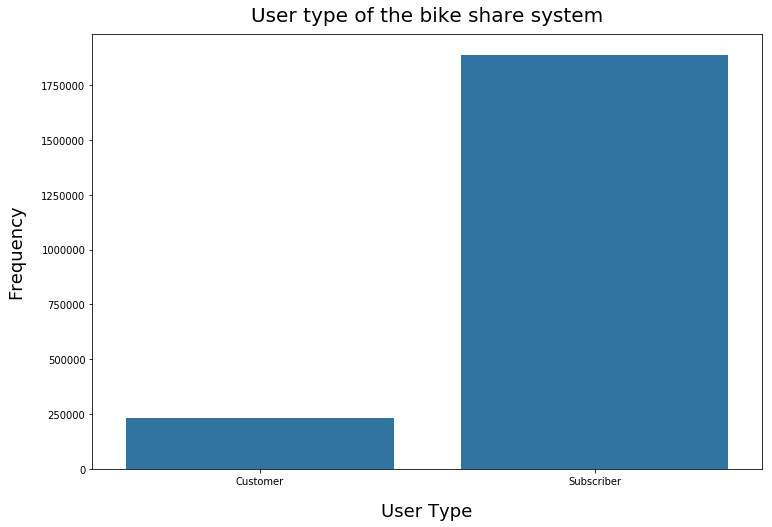

In [164]:
plt.figure(figsize=(12,8))
sb.barplot(data=user_df, x='user_type', y='count', color = base_color)
plt.title("User type of the bike share system", fontsize=20, y=1.015)
plt.xlabel('User Type', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)

We can see that the amount of subscriber is more than 1.75 mil, compared to the 25k non-subscriber customer

Text(0.5,1.03,'User gender of the bike share system')

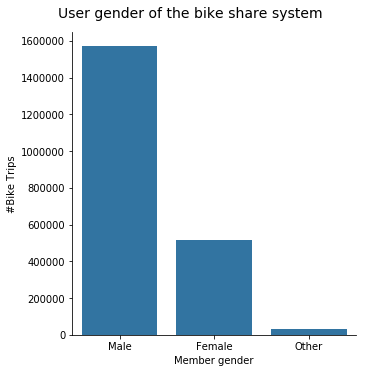

In [75]:
g = sb.catplot(data=df5, x='member_gender', kind='count', color = base_color)
g.set_axis_labels("Member gender", "#Bike Trips")
g.fig.suptitle('User gender of the bike share system', y=1.03, fontsize=14)

We can see that for male has the highest usage of almost 1.6 mil compared to the woman with around 600k usage

In [165]:
gender_df = df5.groupby(['member_gender']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
gender_df

,member_gender,count
0,Female,517306
1,Male,1571227
2,Other,32084


In [166]:
df_sf['start_station_name'].value_counts().reset_index()

,index,start_station_name
0,San Francisco Caltrain Station 2 (Townsend St...,46334
1,San Francisco Caltrain (Townsend St at 4th St),43949
2,Market St at 10th St,43416
3,San Francisco Ferry Building (Harry Bridges Pl...,41969
4,Berry St at 4th St,41449
5,Montgomery St BART Station (Market St at 2nd St),39186
6,The Embarcadero at Sansome St,35342
7,Powell St BART Station (Market St at 4th St),35270
8,Howard St at Beale St,34286
9,Steuart St at Market St,33841


In [167]:
df_eb['start_station_name'].value_counts().reset_index()

,index,start_station_name
0,19th Street BART Station,20754
1,Bancroft Way at College Ave,16127
2,MacArthur BART Station,15682
3,Lake Merritt BART Station,12058
4,Bancroft Way at Telegraph Ave,11815
5,Grand Ave at Perkins St,11033
6,Bay Pl at Vernon St,10974
7,Frank H Ogawa Plaza,10393
8,2nd Ave at E 18th St,10222
9,El Embarcadero at Grand Ave,10019


In [168]:
df_sj['start_station_name'].value_counts().reset_index()

,index,start_station_name
0,San Fernando St at 4th St,8275
1,San Jose Diridon Station,7623
2,5th St at Virginia St,7555
3,Ryland Park,5592
4,San Salvador St at 9th St,4684
5,Julian St at The Alameda,3848
6,Paseo De San Antonio at 2nd St,3502
7,San Fernando at 7th St,3405
8,The Alameda at Bush St,3377
9,San Jose City Hall,3043


### Bivariate 
So we will focus on the 6 variables to answer our big question: 
1. Area  
2. User type  
3. Start Hours 
4. Start Year Months 
5. Start Weekdays
6. Trip Duration

In [76]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120617 entries, 12 to 2383419
Data columns (total 26 columns):
bike_id                    object
bike_share_for_all_trip    object
duration_sec               float64
end_station_id             float64
end_station_name           object
end_time                   datetime64[ns]
member_gender              object
start_station_id           float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
area                       object
start_time_date            object
end_time_date              object
start_time_year_month      object
end_time_year_month        object
start_time_hour_minute     object
end_time_hour_minute       object
start_time_hour            int64
end_time_hour              int64
start_time_weekday         object
end_time_weekday           object
start_time_weekday_abbr    object
end_time_weekday_abbr      object
duration_min        

### User Type


In [77]:
user_type_count_df = df5.groupby(["start_time_year_month", "user_type"]).size().reset_index()
user_type_count_df

,start_time_year_month,user_type,0
0,2017-06,Customer,124
1,2017-06,Subscriber,2114
2,2017-07,Customer,4229
3,2017-07,Subscriber,29632
4,2017-08,Customer,8287
5,2017-08,Subscriber,58302
6,2017-09,Customer,10326
7,2017-09,Subscriber,71669
8,2017-10,Customer,8424
9,2017-10,Subscriber,83158


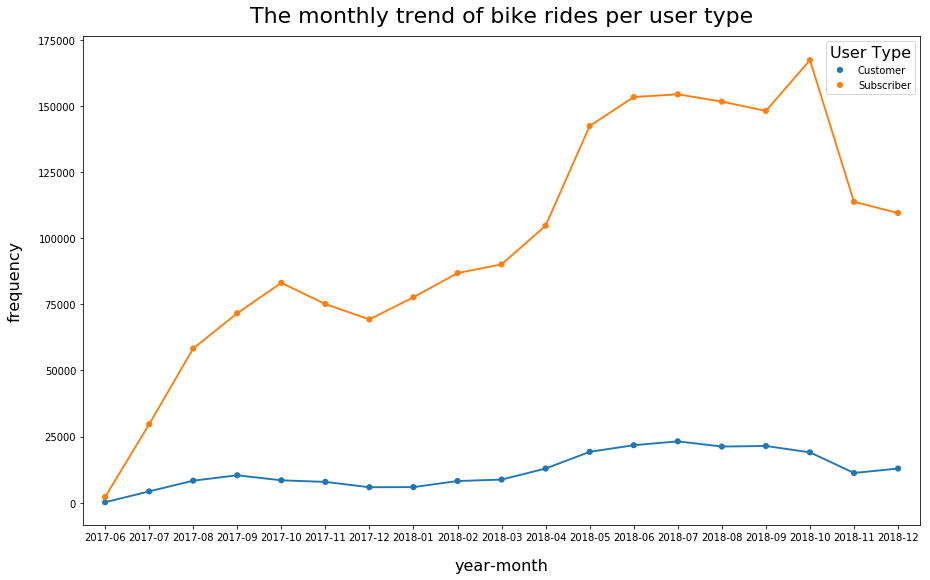

In [79]:
plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_time_year_month', y=0, hue='user_type', data=user_type_count_df)
plt.title('The monthly trend of bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('year-month', fontsize=16, labelpad=16)
plt.ylabel('frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})

It appears that subscribers have been a rising massive trends compared to normal customers with each have similar trends with each other

In [80]:
user_type_count_df2 = df5.groupby(["start_time_weekday_abbr", "user_type"]).size().reset_index()
user_type_count_df2

,start_time_weekday_abbr,user_type,0
0,Fri,Customer,35484
1,Fri,Subscriber,298134
2,Mon,Customer,28530
3,Mon,Subscriber,313331
4,Sat,Customer,39291
5,Sat,Subscriber,141739
6,Sun,Customer,33617
7,Sun,Subscriber,125630
8,Thu,Customer,32792
9,Thu,Subscriber,330594


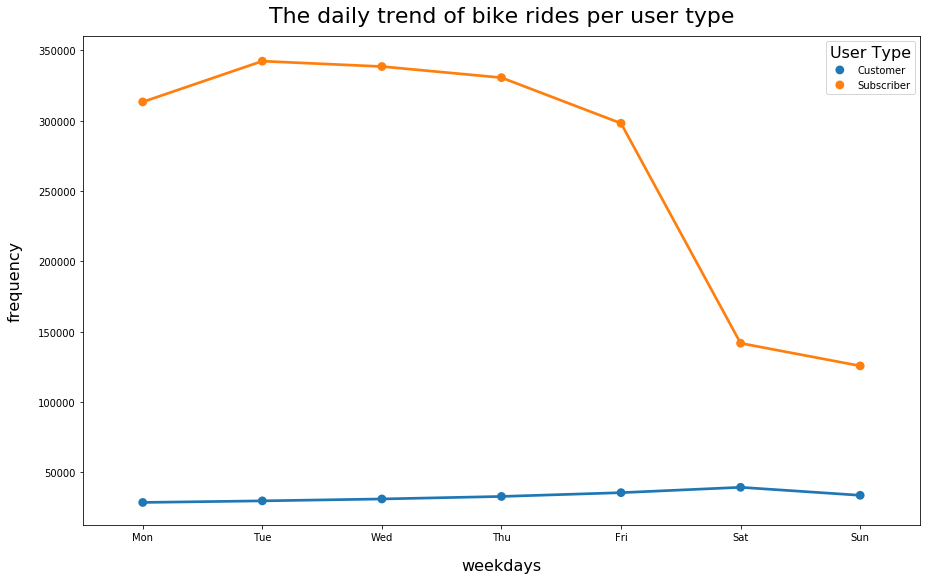

In [82]:
plt.figure(figsize=(15,9))
dayorder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sb.pointplot(x='start_time_weekday_abbr', y=0, hue='user_type', data=user_type_count_df2, order= dayorder)
plt.title('The daily trend of bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('weekdays', fontsize=16, labelpad=16)
plt.ylabel('frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})

With this graph we can see that in the weekdays, the normal customer does not have any significant changes (even increasing in weekends) while the subscriber have massive drop in the weekends usage which means that the biggest contributor is the weekdays transportation

In [83]:
user_type_count_df3 = df5.groupby(["start_time_hour", "user_type"]).size().reset_index()
user_type_count_df3

,start_time_hour,user_type,0
0,0,Customer,1381
1,0,Subscriber,9768
2,1,Customer,759
3,1,Subscriber,5365
4,2,Customer,483
5,2,Subscriber,3238
6,3,Customer,170
7,3,Subscriber,1891
8,4,Customer,203
9,4,Subscriber,2541


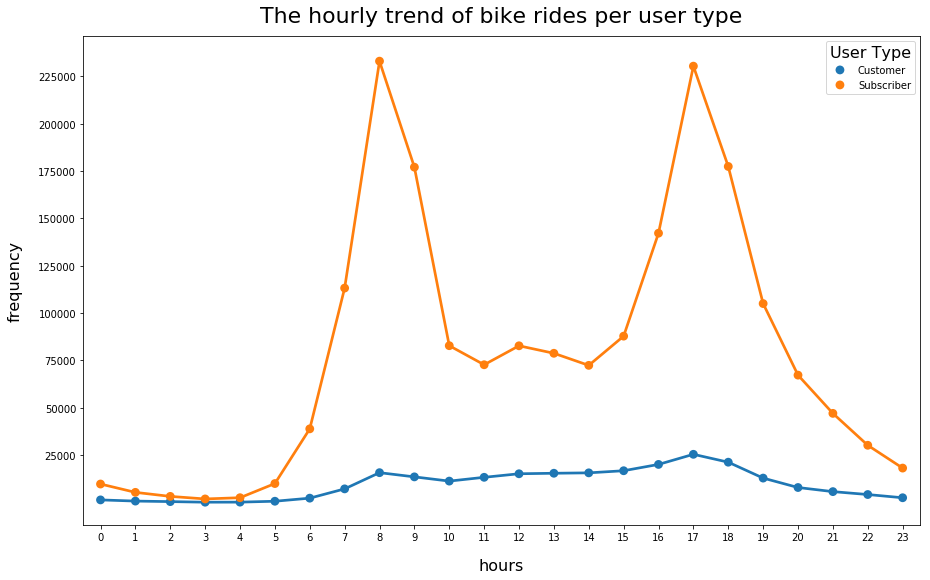

In [192]:
plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_time_hour', y=0, hue='user_type', data=user_type_count_df3)
plt.title('The hourly trend of bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('hours', fontsize=16, labelpad=16)
plt.ylabel('frequency', fontsize=16, labelpad=16)
ticks =  [25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000]
labels = ['{}'.format(val) for val in ticks]
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
plt.yticks(ticks,labels)
ax = plt.gca()

Within the hours, it is the same as the trends which the heaviest traffic refers to 8am and 5pm especially for subscriber which have indication that high daily usage for transportation between work and home

Text(0,0.5,'duration_min')

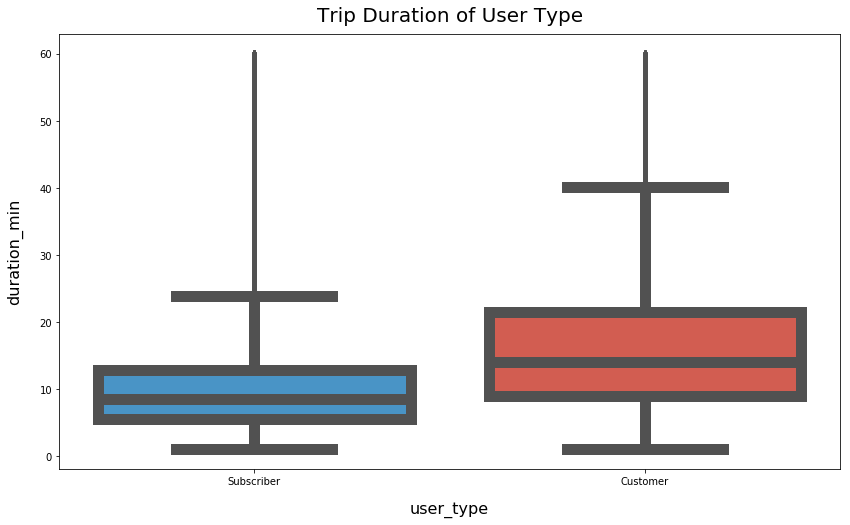

In [86]:
plt.figure(figsize=(14,8))
my_palette = {'Subscriber':'#3498db', 'Customer':'#e74c3c'}
ax = sb.boxplot(x='user_type', y='duration_min', linewidth=11, palette=my_palette, data= df5)
plt.title('Trip Duration of User Type', fontsize=20, y=1.015)
plt.xlabel('user_type', fontsize=16, labelpad=16)
plt.ylabel('duration_min', fontsize=16, labelpad=16)

By going with the boxplot, we can see that the subscriber have lower duration trip overall compared to customer duration trip. Subscriber who have heavier usage might use it as a means of daily transportation while the customer who did not use it daily might have more irregular and longer trips 

In [87]:
user_type_count_df4 = df5.groupby(["area", "user_type"]).size().reset_index()
user_type_count_df4

,area,user_type,0
0,EB,Customer,46614
1,EB,Subscriber,399218
2,SF,Customer,177857
3,SF,Subscriber,1400666
4,SJ,Customer,5750
5,SJ,Subscriber,90233
6,Temp,Customer,148
7,Temp,Subscriber,131


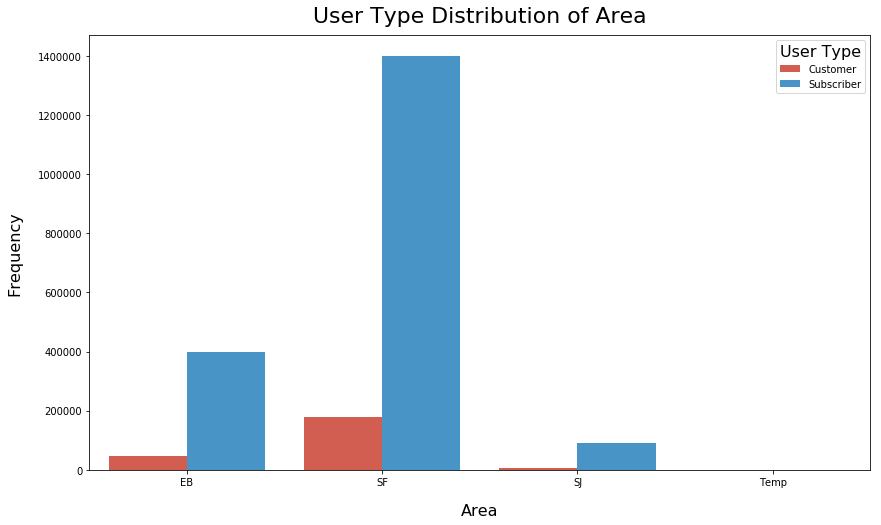

In [88]:
plt.figure(figsize=(14,8))
my_palette = {'Subscriber':'#3498db', 'Customer':'#e74c3c'}
ax = sb.barplot(x='area', y=0, hue='user_type', palette=my_palette, data=user_type_count_df4)
plt.title('User Type Distribution of Area', fontsize=22, y=1.015)
plt.xlabel('Area', fontsize=16,labelpad=16)
plt.ylabel('Frequency', fontsize=16,labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()

In [89]:
df_temp['user_type'].value_counts()

Customer      148
Subscriber    131
Name: user_type, dtype: int64

When we see that the most concentrated area is in San Fransisco, the HQ of Ford Go Bike. This result is the same with the univariate graph of the area distribution which means area might not have big impact 

### Area

In [90]:
area_count_df = df5.groupby(["start_time_hour", "area"]).size().reset_index()
area_count_df

,start_time_hour,area,0
0,0,EB,3186
1,0,SF,6569
2,0,SJ,1394
3,1,EB,1382
4,1,SF,3602
5,1,SJ,1140
6,2,EB,673
7,2,SF,2236
8,2,SJ,812
9,3,EB,423


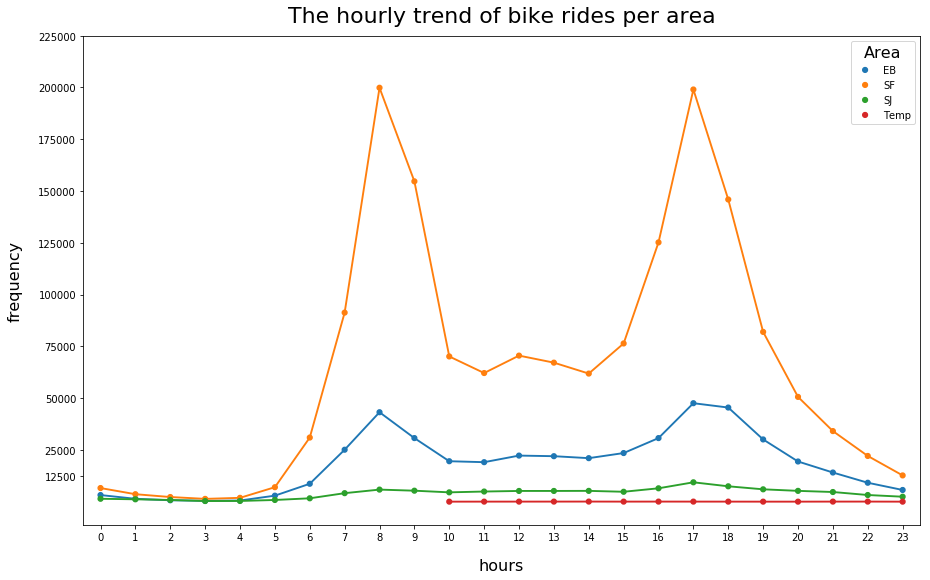

In [91]:
plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_time_hour', y=0, hue='area', scale=.7, data=area_count_df)
plt.title('The hourly trend of bike rides per area', fontsize=22, y=1.015)
plt.xlabel('hours', fontsize=16, labelpad=16)
plt.ylabel('frequency', fontsize=16, labelpad=16)
ticks =  [12500, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000]
labels = ['{}'.format(val) for val in ticks]
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.yticks(ticks,labels)
ax = plt.gca()

It appears that the temporary stations only operational betwen 10am and 11pm while the rest of the areas have the same trends with minor differences with San Jose area which does not fluctuate that much 

In [92]:
area_count_df2 = df5.groupby(["start_time_year_month", "area"]).size().reset_index()
area_count_df2

,start_time_year_month,area,0
0,2017-06,SF,2238
1,2017-07,EB,4112
2,2017-07,SF,29115
3,2017-07,SJ,634
4,2017-08,EB,11657
5,2017-08,SF,53234
6,2017-08,SJ,1698
7,2017-09,EB,14707
8,2017-09,SF,65140
9,2017-09,SJ,2148


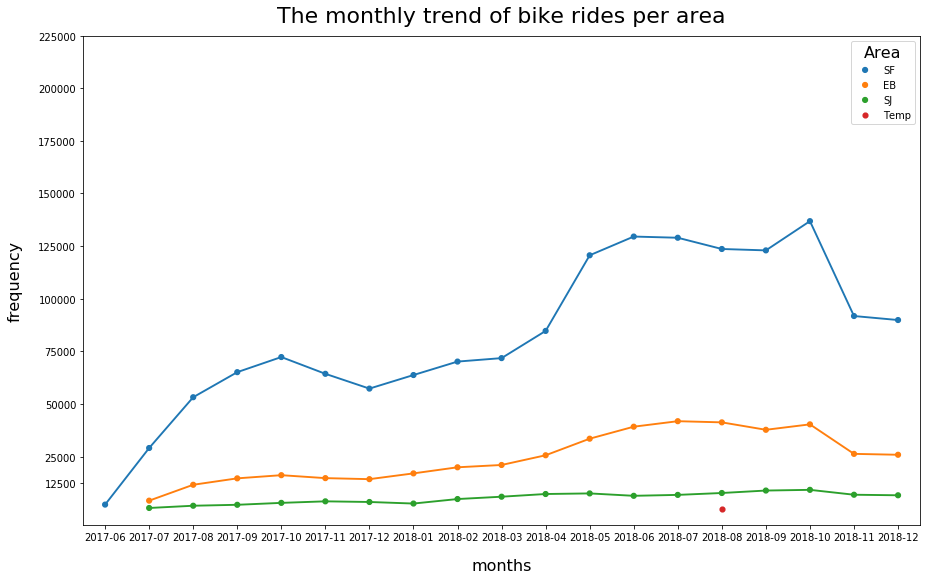

In [93]:
plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_time_year_month', y=0, hue='area', scale=.7, data=area_count_df2)
plt.title('The monthly trend of bike rides per area', fontsize=22, y=1.015)
plt.xlabel('months', fontsize=16, labelpad=16)
plt.ylabel('frequency', fontsize=16, labelpad=16)
ticks =  [12500, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000]
labels = ['{}'.format(val) for val in ticks]
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.yticks(ticks,labels)
ax = plt.gca()

So the reason why in the june 2017 is so low because it only started operations and only available in San Fransisco and after that there are some rising trends and decreasing while in november and december. The reason for the decrease is might be the weather and holidays. Temporary stations only available in August 2018.

In [94]:
area_count_df3 = df5.groupby(["start_time_weekday_abbr", "area"]).size().reset_index()
area_count_df3

,start_time_weekday_abbr,area,0
0,Fri,EB,67947
1,Fri,SF,251801
2,Fri,SJ,13817
3,Fri,Temp,53
4,Mon,EB,69094
5,Mon,SF,257540
6,Mon,SJ,15227
7,Sat,EB,46577
8,Sat,SF,124238
9,Sat,SJ,10061


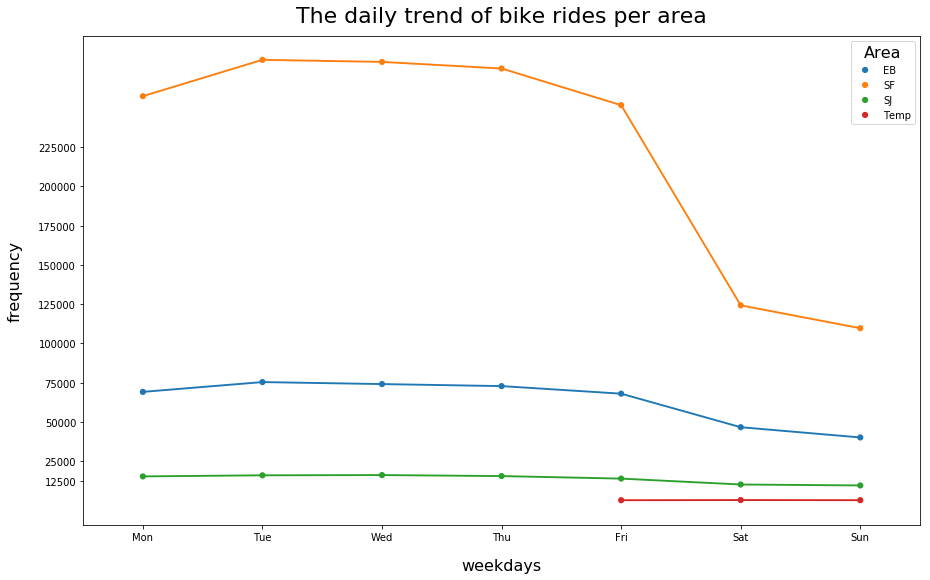

In [95]:
plt.figure(figsize=(15,9))
dayorder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sb.pointplot(x='start_time_weekday_abbr', y=0, hue='area', scale=.7, data=area_count_df3, order=dayorder)
plt.title('The daily trend of bike rides per area', fontsize=22, y=1.015)
plt.xlabel('weekdays', fontsize=16, labelpad=16)
plt.ylabel('frequency', fontsize=16, labelpad=16)
ticks =  [12500, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000]
labels = ['{}'.format(val) for val in ticks]
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.yticks(ticks,labels)
ax = plt.gca()

So in temporary stations, it only operational from friday-sunday while the other areas have the same trend with San Fransisco as the most fluctuative around weekends (San Jose is the one with the least fluctuation)

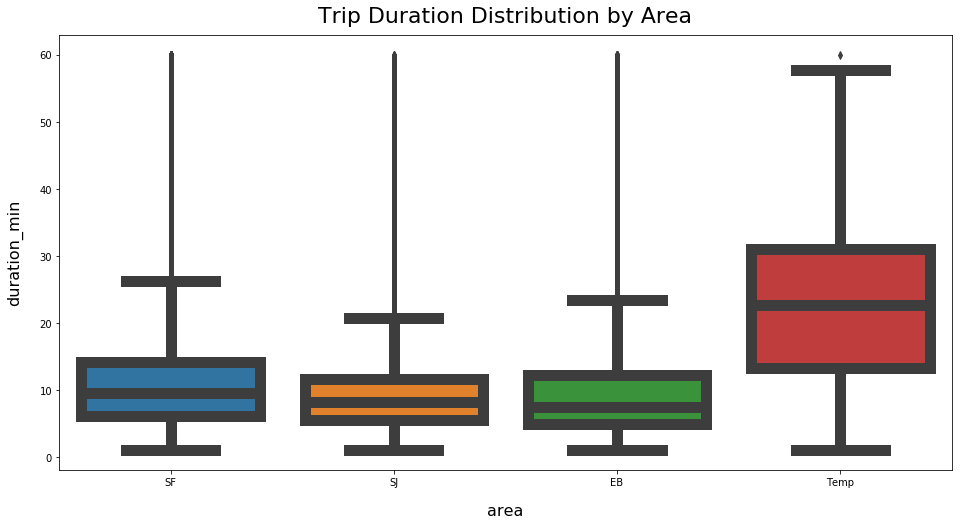

In [96]:
plt.figure(figsize=(16,8))
ax = sb.boxplot(x='area', y='duration_min', linewidth=11, data= df5)
plt.title('Trip Duration Distribution by Area', fontsize=22, y=1.015)
plt.xlabel('area', fontsize=16, labelpad=16)
plt.ylabel('duration_min', fontsize=16, labelpad=16)
g.fig.set_figwidth(20)

In [97]:
df_temp['duration_min'].mean()

22.822461170848282

The average duration trip of San Fransisco is 10 minutes with both San Jose and East Bay are under 10 minutes while temporary station's average duration trip is more than 20 minutes

### Hours, Months and Day

In [98]:
hour_df = df5.groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
hour_df

,start_time_weekday_abbr,start_time_hour,count
0,Fri,0,1618
1,Fri,1,801
2,Fri,2,410
3,Fri,3,277
4,Fri,4,410
5,Fri,5,1753
6,Fri,6,6587
7,Fri,7,19787
8,Fri,8,42435
9,Fri,9,32762


In [99]:
hour_df['start_time_weekday_abbr'] = pd.Categorical(hour_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [100]:
hour_df['count_perc'] = hour_df['count'].apply(lambda x: (x/hour_df['count'].sum())*100)
hour_df

,start_time_weekday_abbr,start_time_hour,count,count_perc
0,Fri,0,1618,0.076299
1,Fri,1,801,0.037772
2,Fri,2,410,0.019334
3,Fri,3,277,0.013062
4,Fri,4,410,0.019334
5,Fri,5,1753,0.082665
6,Fri,6,6587,0.310617
7,Fri,7,19787,0.933077
8,Fri,8,42435,2.001069
9,Fri,9,32762,1.544928


In [101]:
hour_df['rank'] = hour_df['count_perc'].rank(ascending=False).astype(int)
hour_df

,start_time_weekday_abbr,start_time_hour,count,count_perc,rank
0,Fri,0,1618,0.076299,132
1,Fri,1,801,0.037772,142
2,Fri,2,410,0.019334,154
3,Fri,3,277,0.013062,162
4,Fri,4,410,0.019334,154
5,Fri,5,1753,0.082665,131
6,Fri,6,6587,0.310617,103
7,Fri,7,19787,0.933077,34
8,Fri,8,42435,2.001069,9
9,Fri,9,32762,1.544928,19


In [102]:
hour_df_pivoted = hour_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank').astype(int)
hour_df_pivoted

start_time_weekday_abbr,Mon,Tue,Wed,Thu,Fri,Sat,Sun
start_time_hour,,,,,,,
0,139,137,136,135,132,122,123
1,148,146,144,145,142,133,134
2,157,161,160,156,154,141,140
3,167,166,168,165,162,159,153
4,151,149,150,152,154,164,162
5,130,124,126,128,131,147,157
6,99,93,96,97,103,138,143
7,29,25,27,28,34,121,129
8,8,1,2,3,9,105,114


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]), <a list of 24 Text yticklabel objects>)

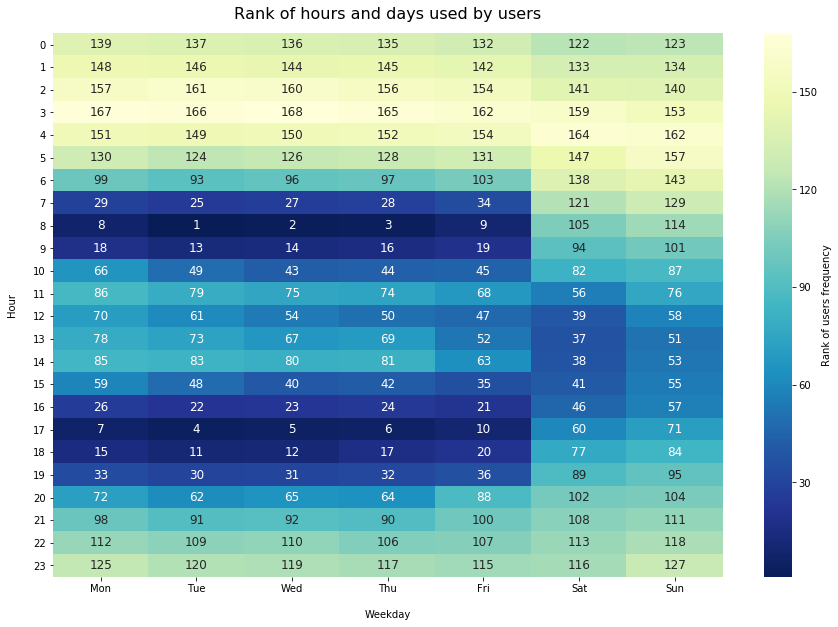

In [103]:
plt.figure(figsize=(15,10))
sb.heatmap(hour_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12},cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of hours and days used by users", fontsize=16, y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour', labelpad=16)
plt.yticks(rotation=360)

We can see that in this heatmap, the crowdest usage is at the lines of 8am and 5pm between monday until friday. The crowdest moment is tuesday at 8am. The 6 top ranking are 8am and 5pm between tuesday until thursday

In [104]:
month_df = df5.groupby(['start_time_year_month', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
month_df['count_perc'] = month_df['count'].apply(lambda x: (x/month_df['count'].sum())*100)
month_df['rank'] = month_df['count_perc'].rank(ascending=False).astype(int)
month_df

,start_time_year_month,start_time_hour,count,count_perc,rank
0,2017-06,0,5,0.000236,452
1,2017-06,1,1,0.000047,453
2,2017-06,5,9,0.000424,451
3,2017-06,6,36,0.001698,442
4,2017-06,7,106,0.004999,419
5,2017-06,8,244,0.011506,379
6,2017-06,9,209,0.009856,391
7,2017-06,10,103,0.004857,423
8,2017-06,11,91,0.004291,429
9,2017-06,12,89,0.004197,430


In [105]:
month_df_pivoted = month_df.pivot_table(index='start_time_hour', columns='start_time_year_month', values='rank').fillna(0).astype(int)
month_df_pivoted

start_time_year_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
start_time_hour,,,,,,,,,,,,,,,,,,,
0,452,417,376,355,359,357,348,363,348,347,338,326,323,321,329,314,312,330,315
1,453,442,405,385,389,393,389,399,394,381,370,351,346,342,350,337,339,344,340
2,0,448,436,423,412,418,407,428,409,412,397,371,372,367,386,358,352,368,360
3,0,449,445,439,440,436,434,441,433,420,406,392,398,403,416,382,384,401,383
4,0,445,435,423,431,420,404,427,414,409,411,400,387,377,402,380,373,396,378
5,451,409,374,369,361,362,366,356,354,352,343,332,320,318,316,317,309,327,334
6,442,336,305,296,288,292,306,287,280,286,272,250,233,226,223,236,208,255,265
7,419,276,220,177,160,167,201,162,155,159,129,69,56,60,53,68,51,96,145
8,379,195,86,57,40,54,72,47,38,39,28,12,10,9,6,11,2,22,33


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]), <a list of 24 Text yticklabel objects>)

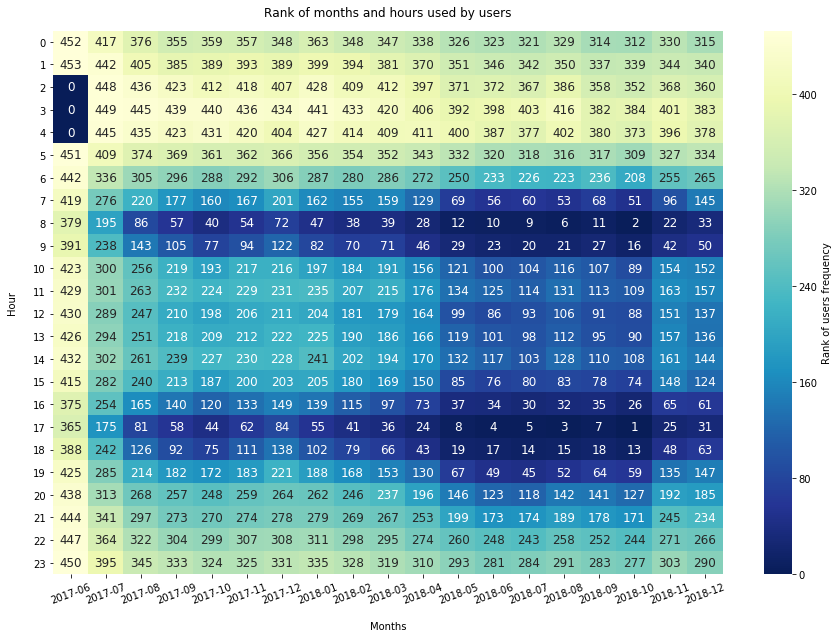

In [106]:
plt.figure(figsize=(15,10))
sb.heatmap(month_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of months and hours used by users", y=1.015)
plt.xlabel('Months', labelpad=16)
plt.ylabel('Hour', labelpad=16)
plt.xticks(rotation=380)
plt.yticks(rotation=360)

It appears that the trend of months have its heaviest traffic during 8am and 5pm in May 2018 until October 2018; then, the usage drops at November and December. 

In [107]:
days_df = df5.groupby(['start_time_year_month', 'start_time_weekday_abbr']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
days_df['start_time_weekday_abbr'] = pd.Categorical(days_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
days_df['count_perc'] = days_df['count'].apply(lambda x: (x/days_df['count'].sum())*100)
days_df['rank'] = days_df['count_perc'].rank(ascending=False).astype(int)
days_df_pivoted = days_df.pivot_table(index='start_time_weekday_abbr', columns='start_time_year_month', values='rank').fillna(0).astype(int)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text yticklabel objects>)

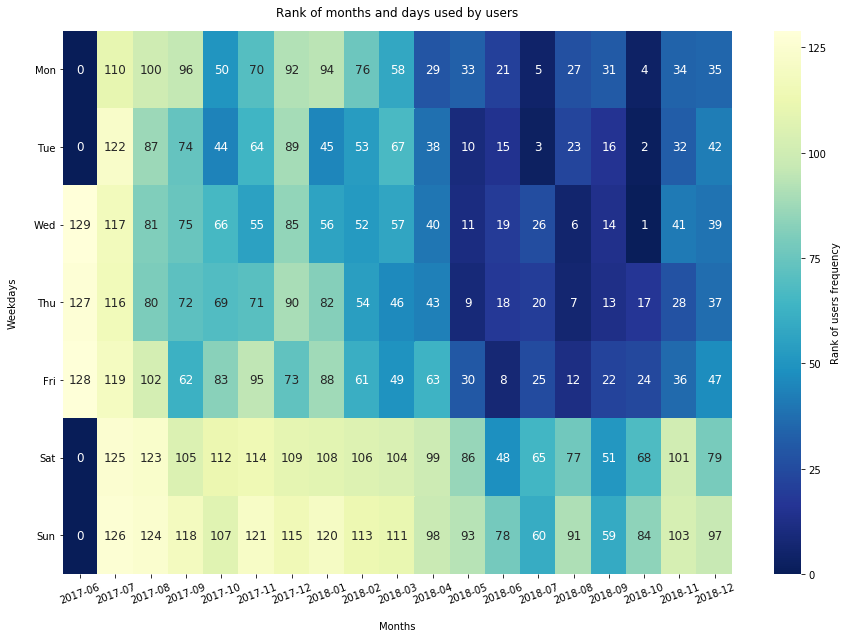

In [108]:
plt.figure(figsize=(15,10))
sb.heatmap(days_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of months and days used by users", y=1.015)
plt.xlabel('Months', labelpad=16)
plt.ylabel('Weekdays', labelpad=16)
plt.xticks(rotation=380)
plt.yticks(rotation=360)

We can see that from the heaviest traffic for the combinations are monday-wednesday in October 2018 and Monday-Tuesday in July 2018. The rest that followed are Wednesday-Thursday in August 2018 and Friday in June 2018. 

### Trip Duration

C:\Users\ASUS\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Trip Duration')

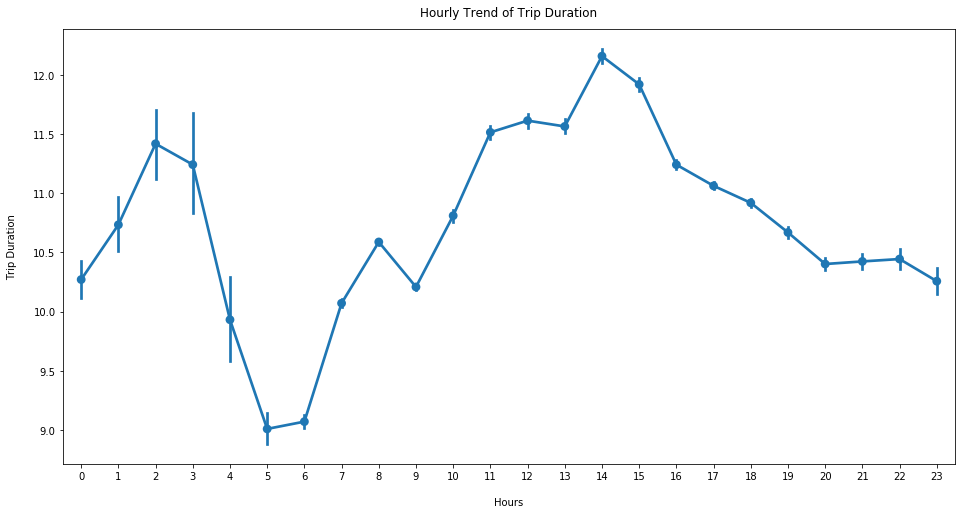

In [110]:
plt.figure(figsize=(16,8))
ax = sb.pointplot(x='start_time_hour', y='duration_min', linewidth=11, data= df5)
plt.title('Hourly Trend of Trip Duration', y=1.015)
plt.xlabel('Hours', labelpad=16)
plt.ylabel('Trip Duration', labelpad=16)

Text(0,0.5,'Trip Duration')

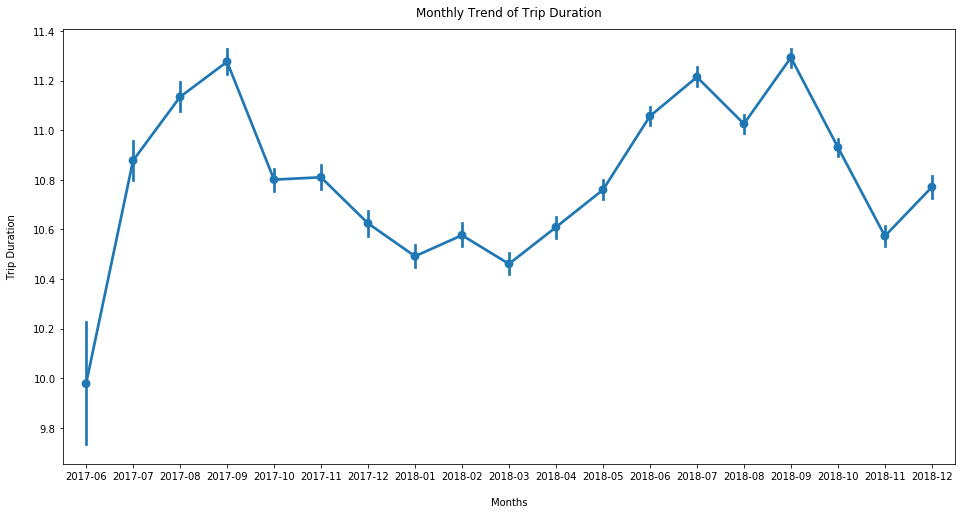

In [112]:
plt.figure(figsize=(16,8))
ax = sb.pointplot(x='start_time_year_month', y='duration_min', linewidth=11, data= df5, order=yearmonth)
plt.title('Monthly Trend of Trip Duration', y=1.015)
plt.xlabel('Months', labelpad=16)
plt.ylabel('Trip Duration', labelpad=16)

Text(0,0.5,'Trip Duration')

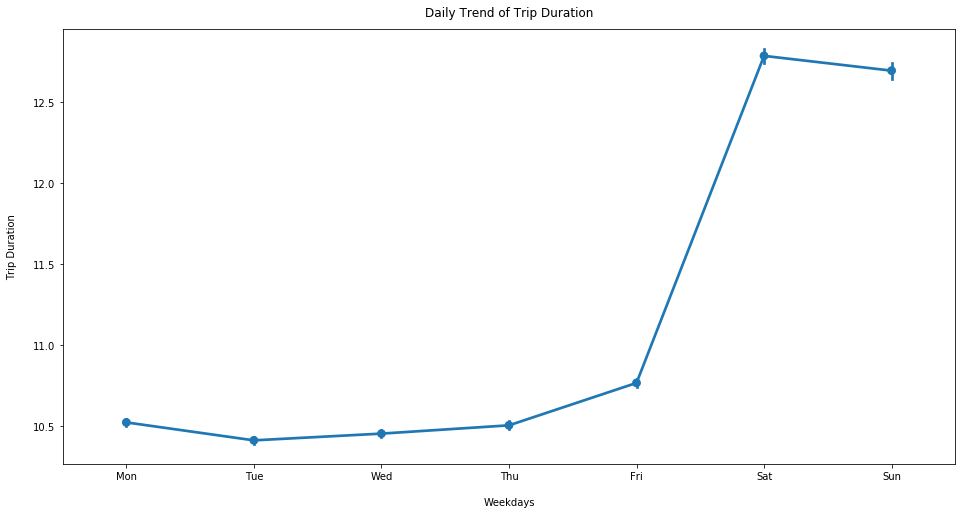

In [114]:
plt.figure(figsize=(16,8))
ax = sb.pointplot(x='start_time_weekday_abbr', y='duration_min', linewidth=11, data= df5, order=dayorder)
plt.title('Daily Trend of Trip Duration', y=1.015)
plt.xlabel('Weekdays', labelpad=16)
plt.ylabel('Trip Duration', labelpad=16)

### Multivariate
#### Duration & Area

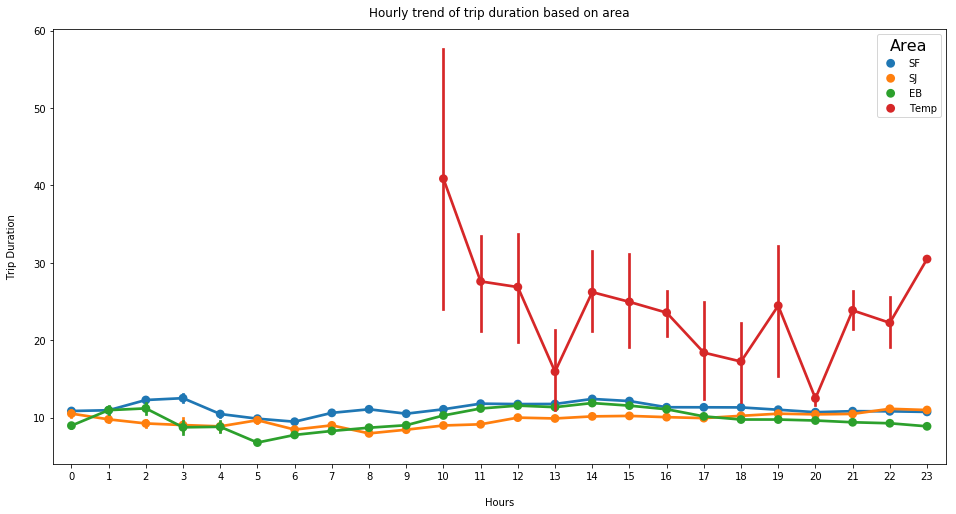

In [115]:
plt.figure(figsize=(16,8))
ax = sb.pointplot(x='start_time_hour', y='duration_min', hue='area', linewidth=11, data= df5)
plt.title('Hourly trend of trip duration based on area', y=1.015)
plt.xlabel('Hours', labelpad=16)
plt.ylabel('Trip Duration', labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
ax = plt.gca()

So we can see in here that the trip duration have the same durations for almost all areas except temporary stations where their trip durations are longer. Might be the trip durations are longer due to the lack of ready stations

In [116]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120617 entries, 12 to 2383419
Data columns (total 26 columns):
bike_id                    object
bike_share_for_all_trip    object
duration_sec               float64
end_station_id             float64
end_station_name           object
end_time                   datetime64[ns]
member_gender              object
start_station_id           float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
area                       object
start_time_date            object
end_time_date              object
start_time_year_month      object
end_time_year_month        object
start_time_hour_minute     object
end_time_hour_minute       object
start_time_hour            int64
end_time_hour              int64
start_time_weekday         object
end_time_weekday           object
start_time_weekday_abbr    object
end_time_weekday_abbr      object
duration_min        

In [117]:
df5.head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_name,end_time,member_gender,start_station_id,start_station_name,start_time,...,end_time_year_month,start_time_hour_minute,end_time_hour_minute,start_time_hour,end_time_hour,start_time_weekday,end_time_weekday,start_time_weekday_abbr,end_time_weekday_abbr,duration_min
12,2311,NaN,2183.0,24.0,Spear St at Folsom St,2018-01-01 00:29:18.743,Male,67.0,San Francisco Caltrain Station 2 (Townsend St...,2017-12-31 23:52:55.581,...,2018-01,23-12,00-01,23,0,Sunday,Monday,Sun,Mon,36.383333
13,3717,NaN,2170.0,24.0,Spear St at Folsom St,2018-01-01 00:29:06.924,Male,67.0,San Francisco Caltrain Station 2 (Townsend St...,2017-12-31 23:52:55.937,...,2018-01,23-12,00-01,23,0,Sunday,Monday,Sun,Mon,36.166667
15,558,NaN,1544.0,27.0,Beale St at Harrison St,2018-01-01 00:19:23.047,Female,14.0,Clay St at Battery St,2017-12-31 23:53:38.943,...,2018-01,23-12,00-01,23,0,Sunday,Monday,Sun,Mon,25.733333
16,3646,NaN,1474.0,27.0,Beale St at Harrison St,2018-01-01 00:19:14.351,Male,14.0,Clay St at Battery St,2017-12-31 23:54:40.146,...,2018-01,23-12,00-01,23,0,Sunday,Monday,Sun,Mon,24.566667
18,3114,NaN,1532.0,15.0,San Francisco Ferry Building (Harry Bridges Pl...,2018-01-01 00:18:21.953,Other,78.0,Folsom St at 9th St,2017-12-31 23:52:49.497,...,2018-01,23-12,00-01,23,0,Sunday,Monday,Sun,Mon,25.533333


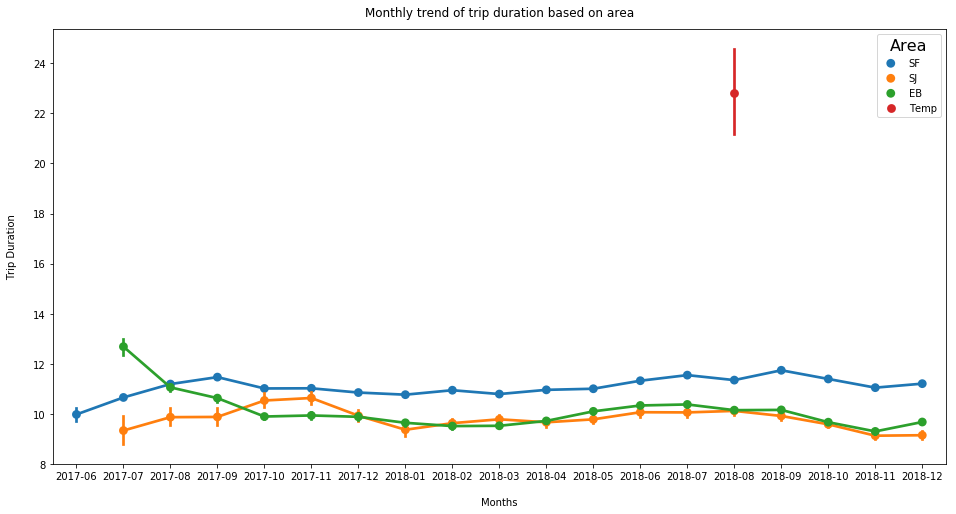

In [118]:
plt.figure(figsize=(16,8))
yearmonth = ['2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']
ax = sb.pointplot(x='start_time_year_month', y='duration_min', hue='area', linewidth=11, data= df5, order=yearmonth)
plt.title('Monthly trend of trip duration based on area', y=1.015)
plt.xlabel('Months', labelpad=16)
plt.ylabel('Trip Duration', labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
ax = plt.gca()

Based on area, there is no significant variation for the other areas except the temporary stations

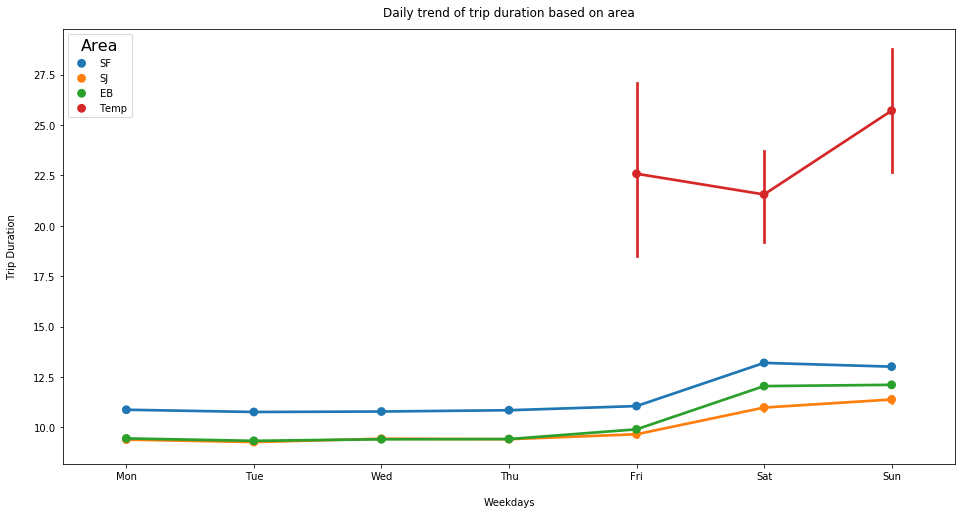

In [119]:
plt.figure(figsize=(16,8))
dayorder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sb.pointplot(x='start_time_weekday_abbr', y='duration_min', hue='area', linewidth=11, data= df5, order=dayorder)
plt.title('Daily trend of trip duration based on area', y=1.015)
plt.xlabel('Weekdays', labelpad=16)
plt.ylabel('Trip Duration', labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
ax = plt.gca()

There are also no differences when it comes to weekdays except teh temporary stations which only available during friday-sunday 

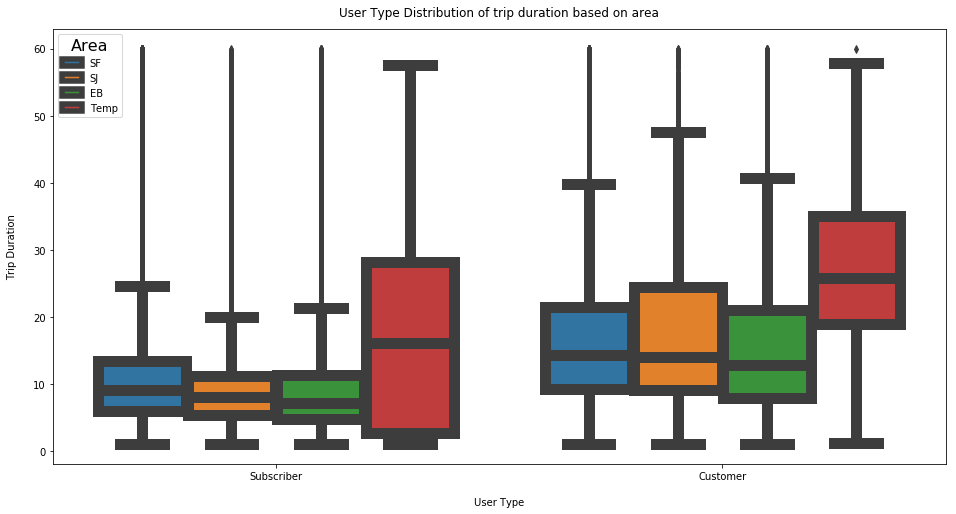

In [120]:
plt.figure(figsize=(16,8))
ax = sb.boxplot(x='user_type', y='duration_min', hue='area', linewidth=11, data= df5)
plt.title('User Type Distribution of trip duration based on area', y=1.015)
plt.xlabel('User Type', labelpad=16)
plt.ylabel('Trip Duration', labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
ax = plt.gca()

With the area factors, the conclusion is the same with the one without areas: the subscriber duration trip is averagely lower than customer duration trip

#### User Type & Area

In [121]:
subs_hour_df = df5[(df5['user_type']== 'Subscriber')].groupby(['start_time_hour', 'area']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
subs_hour_df['count_perc'] = subs_hour_df['count'].apply(lambda x: (x/subs_hour_df['count'].sum())*100)
subs_hour_df['rank'] = subs_hour_df['count_perc'].rank(ascending=False).astype(int)
subs_hour_df_pivoted = subs_hour_df.pivot_table(index='start_time_hour', columns='area', values='rank').fillna(0).astype(int)
subs_hour_df_pivoted

area,EB,SF,SJ,Temp
start_time_hour,,,,
0,56,40,62,0
1,64,54,65,0
2,68,59,67,0
3,70,63,72,0
4,69,60,71,0
5,57,38,66,0
6,35,19,61,0
7,23,6,53,0
8,17,1,41,0


In [122]:
cust_hour_df = df5[(df5['user_type']== 'Customer')].groupby(['start_time_hour', 'area']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
cust_hour_df['count_perc'] = cust_hour_df['count'].apply(lambda x: (x/cust_hour_df['count'].sum())*100)
cust_hour_df['rank'] = cust_hour_df['count_perc'].rank(ascending=False).astype(int)
cust_hour_df_pivoted = cust_hour_df.pivot_table(index='start_time_hour', columns='area', values='rank').fillna(0).astype(int)
cust_hour_df_pivoted

area,EB,SF,SJ,Temp
start_time_hour,,,,
0,42,35,64,0
1,54,41,65,0
2,63,49,68,0
3,68,62,76,0
4,66,61,74,0
5,59,39,71,0
6,40,30,67,0
7,33,13,58,0
8,26,4,55,0


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]), <a list of 24 Text yticklabel objects>)

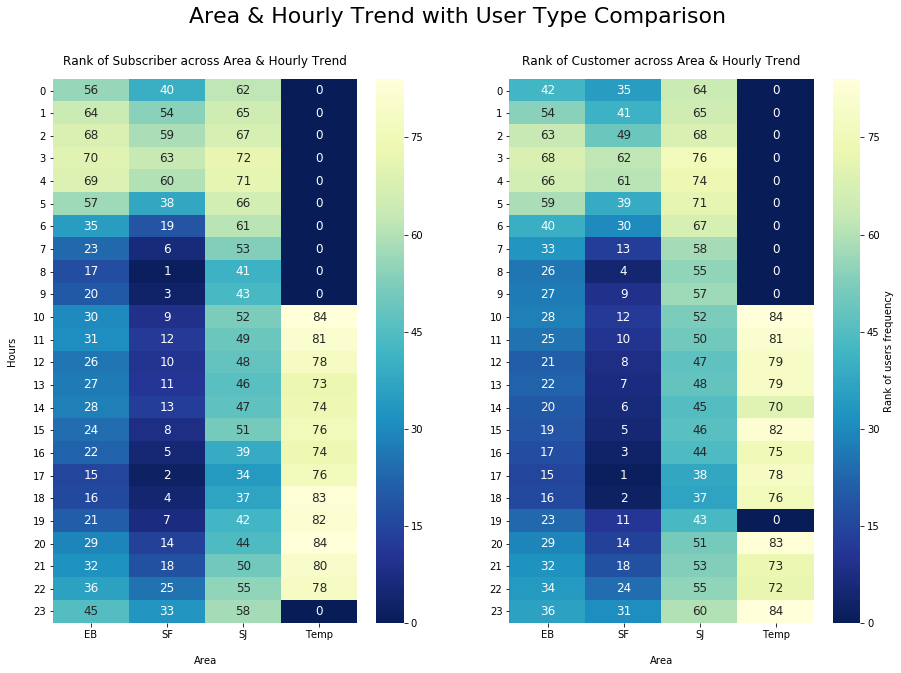

In [123]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.suptitle('Area & Hourly Trend with User Type Comparison', fontsize=22)
sb.heatmap(subs_hour_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12})
plt.title("Rank of Subscriber across Area & Hourly Trend", y=1.015)
plt.xlabel('Area', labelpad=16)
plt.ylabel('Hours', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
sb.heatmap(cust_hour_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of Customer across Area & Hourly Trend", y=1.015)
plt.xlabel('Area', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)

So we find out that both customer and subscriber have the same trend of hours usage and area with the most concentrated for area is San Fransisco and the most concentrated hours are 8am and 5pm. Subscriber have little or minor differences compared to customers 

In [124]:
subs_month_df = df5[(df5['user_type']== 'Subscriber')].groupby(['start_time_year_month', 'area']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
subs_month_df['count_perc'] = subs_month_df['count'].apply(lambda x: (x/subs_month_df['count'].sum())*100)
subs_month_df['rank'] = subs_month_df['count_perc'].rank(ascending=False).astype(int)
subs_month_df_pivoted = subs_month_df.pivot_table(index='start_time_year_month', columns='area', values='rank').fillna(0).astype(int)
subs_month_df_pivoted

area,EB,SF,SJ,Temp
start_time_year_month,,,,
2017-06,0,52,0,0
2017-07,49,24,55,0
2017-08,35,17,54,0
2017-09,34,15,53,0
2017-10,31,10,50,0
2017-11,32,14,47,0
2017-12,33,16,48,0
2018-01,30,13,51,0
2018-02,29,12,46,0


In [125]:
cust_month_df = df5[(df5['user_type']== 'Customer')].groupby(['start_time_year_month', 'area']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
cust_month_df['count_perc'] = cust_month_df['count'].apply(lambda x: (x/cust_month_df['count'].sum())*100)
cust_month_df['rank'] = cust_month_df['count_perc'].rank(ascending=False).astype(int)
cust_month_df_pivoted = cust_month_df.pivot_table(index='start_time_year_month', columns='area', values='rank').fillna(0).astype(int)
cust_month_df_pivoted

area,EB,SF,SJ,Temp
start_time_year_month,,,,
2017-06,0,55,0,0
2017-07,35,24,56,0
2017-08,28,15,48,0
2017-09,30,10,44,0
2017-10,33,11,47,0
2017-11,32,14,49,0
2017-12,36,19,51,0
2018-01,34,20,53,0
2018-02,31,13,46,0


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text yticklabel objects>)

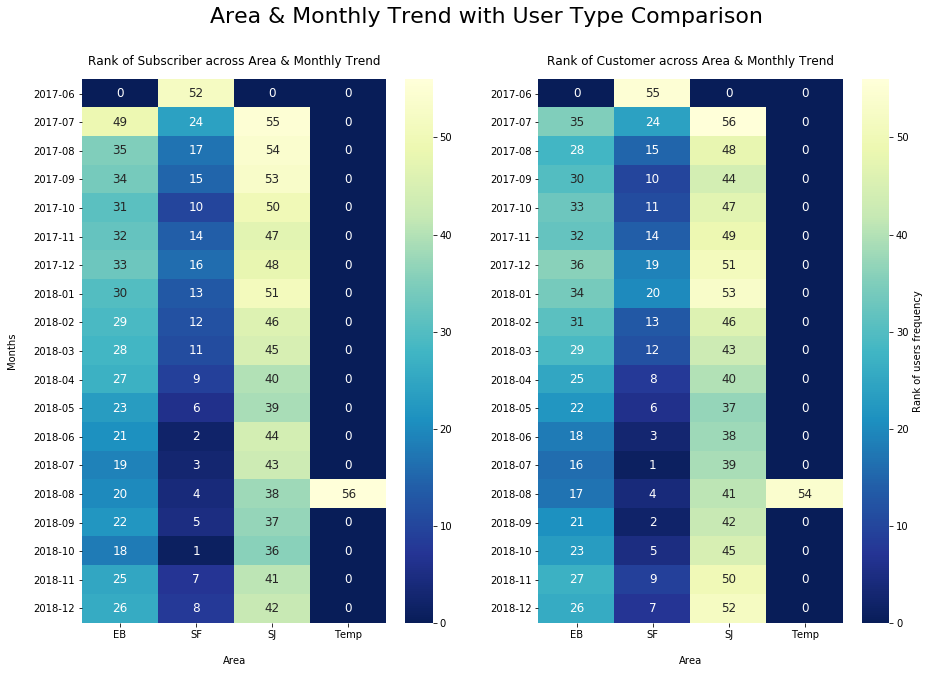

In [126]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.suptitle('Area & Monthly Trend with User Type Comparison', fontsize=22)
sb.heatmap(subs_month_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12})
plt.title("Rank of Subscriber across Area & Monthly Trend", y=1.015)
plt.xlabel('Area', labelpad=16)
plt.ylabel('Months', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
sb.heatmap(cust_month_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of Customer across Area & Monthly Trend", y=1.015)
plt.xlabel('Area', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)

This graph also produced the same trend with the monthly trip trends: increasing trends until there is downtrend for october-november and november-december (With exception of temporary station)

In [140]:
subs_day_df = df5[(df5['user_type']== 'Subscriber')].groupby(['start_time_weekday_abbr', 'area']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
subs_day_df['start_time_weekday_abbr'] = pd.Categorical(subs_day_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
subs_day_df['count_perc'] = subs_day_df['count'].apply(lambda x: (x/subs_day_df['count'].sum())*100)
subs_day_df['rank'] = subs_day_df['count_perc'].rank(ascending=False).astype(int)
subs_day_df_pivoted = subs_day_df.pivot_table(index='start_time_weekday_abbr', columns='area', values='rank').fillna(0).astype(int)
subs_day_df_pivoted

area,EB,SF,SJ,Temp
start_time_weekday_abbr,,,,
Mon,11,4,18,0
Tue,8,1,16,0
Wed,9,2,15,0
Thu,10,3,17,0
Fri,12,5,19,23
Sat,13,6,20,22
Sun,14,7,21,24


In [139]:
cust_day_df = df5[(df5['user_type']== 'Customer')].groupby(['start_time_weekday_abbr', 'area']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
cust_day_df['start_time_weekday_abbr'] = pd.Categorical(cust_day_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
cust_day_df['count_perc'] = cust_day_df['count'].apply(lambda x: (x/cust_day_df['count'].sum())*100)
cust_day_df['rank'] = cust_day_df['count_perc'].rank(ascending=False).astype(int)
cust_day_df_pivoted = cust_day_df.pivot_table(index='start_time_weekday_abbr', columns='area', values='rank').fillna(0).astype(int)
cust_day_df_pivoted

area,EB,SF,SJ,Temp
start_time_weekday_abbr,,,,
Mon,14,7,21,0
Tue,12,6,20,0
Wed,13,5,19,0
Thu,11,3,18,0
Fri,9,2,17,24
Sat,8,1,16,22
Sun,10,4,15,23


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text yticklabel objects>)

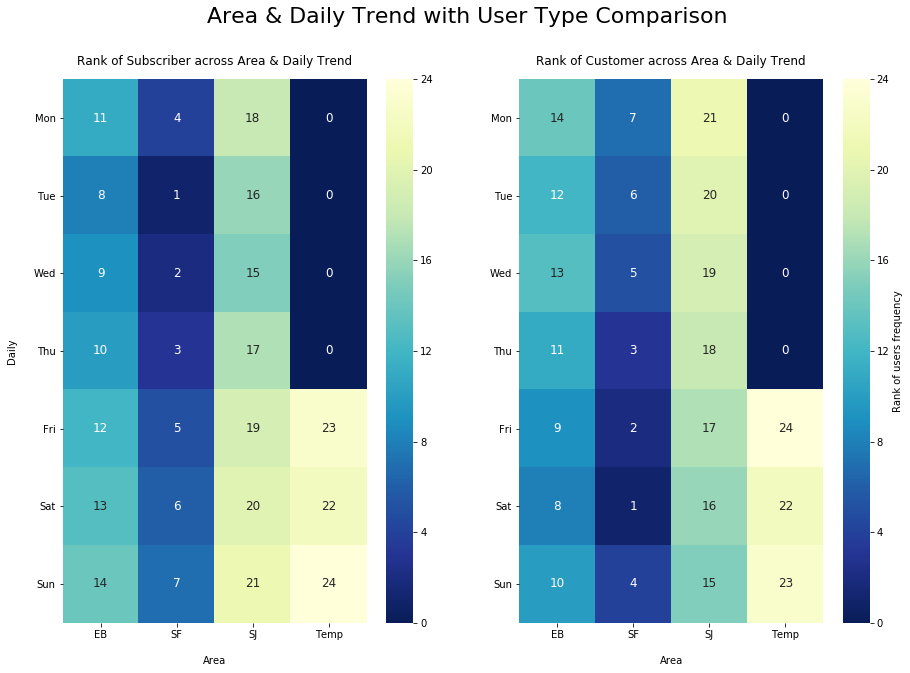

In [141]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.suptitle('Area & Daily Trend with User Type Comparison', fontsize=22)
sb.heatmap(subs_day_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12})
plt.title("Rank of Subscriber across Area & Daily Trend", y=1.015)
plt.xlabel('Area', labelpad=16)
plt.ylabel('Daily', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
sb.heatmap(cust_day_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of Customer across Area & Daily Trend", y=1.015)
plt.xlabel('Area', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)

This graph also following the same trends with other daily graph: Subscribers group will have their busiest trend on weekdays and will have downtrends on the weekends while Customers group is the other way around(busiest on weekends) 

#### User Type

In [130]:
subs_hd_df = df5[(df5['user_type']== 'Subscriber')].groupby(['start_time_hour', 'start_time_weekday_abbr']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
subs_hd_df['start_time_weekday_abbr'] = pd.Categorical(subs_hd_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
subs_hd_df['count_perc'] = subs_hd_df['count'].apply(lambda x: (x/subs_hd_df['count'].sum())*100)
subs_hd_df['rank'] = subs_hd_df['count_perc'].rank(ascending=False).fillna(0).astype(int)
subs_hd_df_pivoted = subs_hd_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank').astype(int)
subs_hd_df_pivoted

start_time_weekday_abbr,Mon,Tue,Wed,Thu,Fri,Sat,Sun
start_time_hour,,,,,,,
0,139,138,136,135,132,122,126
1,149,146,144,145,142,133,134
2,158,161,159,155,156,141,140
3,167,165,168,163,162,159,154
4,151,148,150,152,153,166,164
5,129,123,125,127,130,147,157
6,98,87,93,94,101,137,143
7,29,24,26,28,34,121,131
8,6,1,2,3,9,105,115


In [131]:
cust_hd_df = df5[(df5['user_type']== 'Customer')].groupby(['start_time_hour', 'start_time_weekday_abbr']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
cust_hd_df['start_time_weekday_abbr'] = pd.Categorical(cust_hd_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
cust_hd_df['count_perc'] = cust_hd_df['count'].apply(lambda x: (x/cust_hd_df['count'].sum())*100)
cust_hd_df['rank'] = cust_hd_df['count_perc'].rank(ascending=False).fillna(0).astype(int)
cust_hd_df_pivoted = cust_hd_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank').astype(int)
cust_hd_df_pivoted

start_time_weekday_abbr,Mon,Tue,Wed,Thu,Fri,Sat,Sun
start_time_hour,,,,,,,
0,134,139,138,131,129,117,118
1,146,145,150,144,140,125,127
2,148,159,157,155,153,130,133
3,164,166,167,168,164,149,152
4,158,159,161,162,163,153,156
5,143,135,137,132,135,146,151
6,119,114,112,113,115,141,142
7,91,70,69,76,89,123,122
8,32,26,24,23,28,100,103


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]), <a list of 24 Text yticklabel objects>)

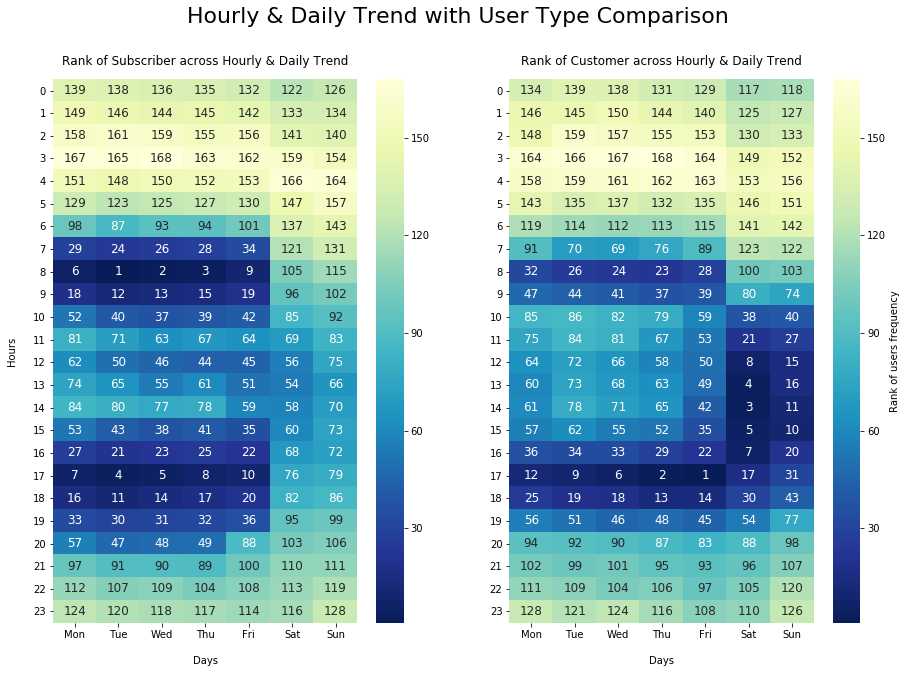

In [132]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.suptitle('Hourly & Daily Trend with User Type Comparison', fontsize=22)
sb.heatmap(subs_hd_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12})
plt.title("Rank of Subscriber across Hourly & Daily Trend", y=1.015)
plt.xlabel('Days', labelpad=16)
plt.ylabel('Hours', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
sb.heatmap(cust_hd_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of Customer across Hourly & Daily Trend", y=1.015)
plt.xlabel('Days', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)

So in this graph, we can learn that the busiest traffic are still at 8am and 5pm in weekdays for subscriber; however, for customers, their busiest traffic are at 5pm in wednesday-friday and 11am-4pm in saturday  

In [133]:
subs_hm_df = df5[(df5['user_type']== 'Subscriber')].groupby(['start_time_hour', 'start_time_year_month']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
subs_hm_df['count_perc'] = subs_hm_df['count'].apply(lambda x: (x/subs_hm_df['count'].sum())*100)
subs_hm_df['rank'] = subs_hm_df['count_perc'].rank(ascending=False).fillna(0).astype(int)
subs_hm_df_pivoted = subs_hm_df.pivot_table(index='start_time_hour', columns='start_time_year_month', values='rank').fillna(0).astype(int)
subs_hm_df_pivoted

start_time_year_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
start_time_hour,,,,,,,,,,,,,,,,,,,
0,452,428,380,364,359,355,349,363,344,346,339,327,324,322,332,315,312,330,318
1,453,443,410,393,389,391,384,400,394,382,372,358,347,343,353,337,338,348,340
2,0,447,439,426,415,418,405,431,411,413,401,370,375,369,395,360,354,368,361
3,0,450,445,438,441,434,434,440,433,419,409,390,396,403,415,384,383,399,381
4,0,446,437,423,430,420,402,421,411,406,408,397,386,378,403,379,371,391,375
5,451,407,374,367,357,356,365,352,351,350,342,329,316,319,313,314,307,325,334
6,441,336,301,291,283,288,298,282,275,281,272,242,226,216,208,223,197,246,260
7,417,273,204,170,157,161,187,156,146,153,109,67,54,55,50,63,47,82,135
8,377,183,79,56,40,52,71,44,33,37,26,12,8,7,3,11,1,18,30


In [134]:
cust_hm_df = df5[(df5['user_type']== 'Customer')].groupby(['start_time_hour', 'start_time_year_month']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
cust_hm_df['count_perc'] = cust_hm_df['count'].apply(lambda x: (x/cust_hm_df['count'].sum())*100)
cust_hm_df['rank'] = cust_hm_df['count_perc'].rank(ascending=False).fillna(0).astype(int)
cust_hm_df_pivoted = cust_hm_df.pivot_table(index='start_time_hour', columns='start_time_year_month', values='rank').fillna(0).astype(int)
cust_hm_df_pivoted

start_time_year_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
start_time_hour,,,,,,,,,,,,,,,,,,,
0,0,369,352,322,359,358,348,362,369,348,321,309,303,294,306,298,306,318,303
1,0,423,371,348,380,386,423,378,386,383,356,339,341,329,335,333,329,324,333
2,0,0,399,390,375,406,423,395,383,386,364,364,355,352,345,352,352,367,357
3,0,440,443,418,433,440,433,0,438,423,375,406,406,395,406,378,392,423,401
4,0,433,406,399,433,418,428,443,418,418,401,423,406,372,386,395,389,428,392
5,446,406,367,378,375,380,418,406,413,383,372,361,344,326,315,336,336,338,343
6,0,366,314,312,319,320,348,342,327,331,302,278,265,260,272,285,270,286,293
7,443,308,262,247,242,261,292,282,253,267,225,133,116,138,126,145,137,189,231
8,428,275,175,110,111,131,195,188,142,146,97,51,40,41,46,44,25,93,102


Text(1290.68,0.5,'Rank of users frequency')

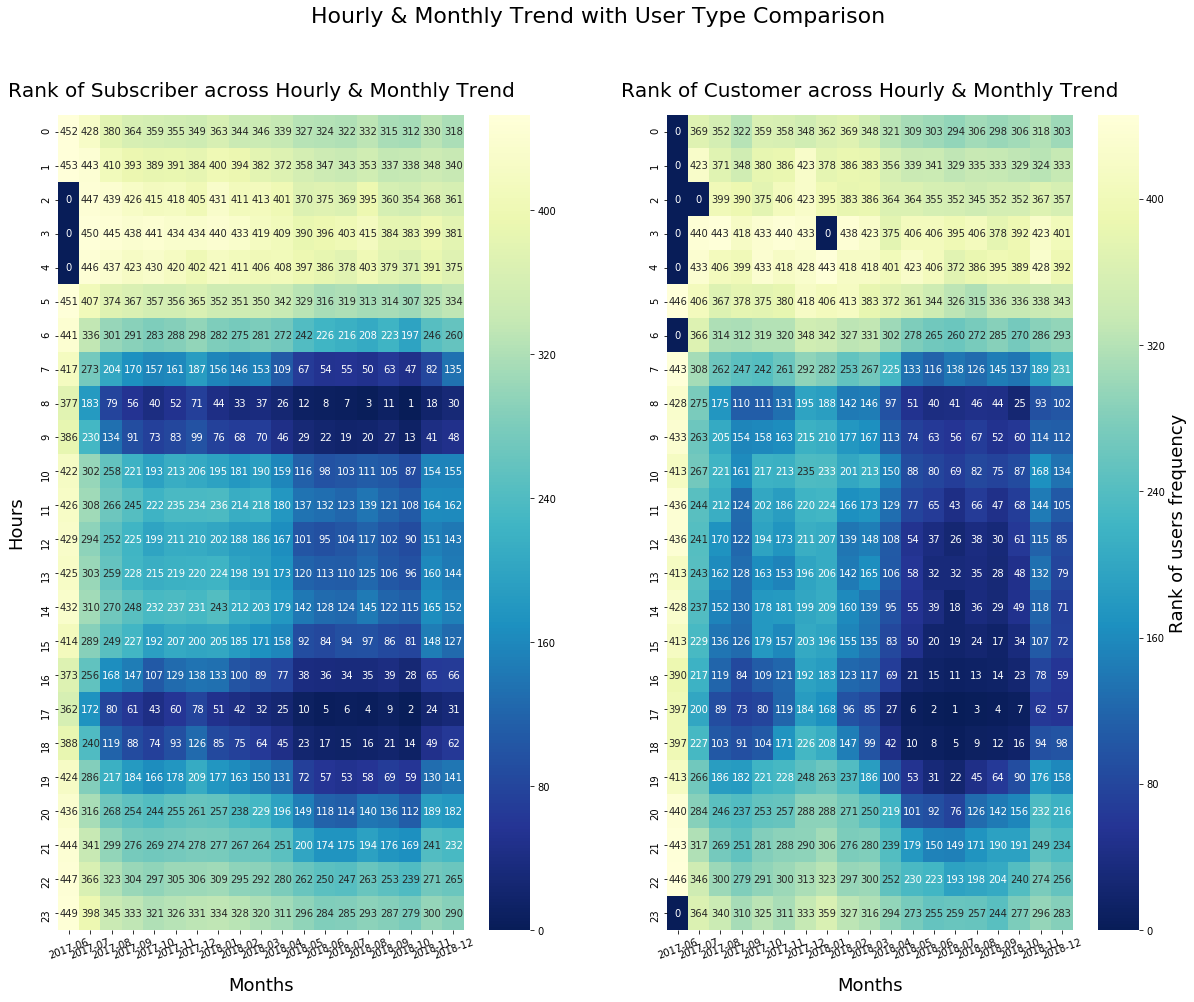

In [142]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.suptitle('Hourly & Monthly Trend with User Type Comparison', fontsize=22)
sb.heatmap(subs_hm_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r',annot_kws={"size": 10})
plt.title("Rank of Subscriber across Hourly & Monthly Trend", fontsize=20, y=1.015)
plt.xlabel('Months', fontsize=18, labelpad=16)
plt.ylabel('Hours', fontsize=18, labelpad=16)
plt.xticks(rotation=380)
plt.subplot(122)
ax = sb.heatmap(cust_hm_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 10}, cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of Customer across Hourly & Monthly Trend", fontsize=20, y=1.015)
plt.xlabel('Months', fontsize=18, labelpad=16)
plt.ylabel(' ')
plt.xticks(rotation=380)
ax.figure.axes[-1].set_ylabel('Rank of users frequency', size=18)

For the trend of between months, we can see that the increasing trends of bike usage with the only falling a bit at november and december. There are slight differences for Subscriber and Customer: Subscriber tends to have consistent trends with 8am and 5pm as the center of the heavy traffic while Customers also have heavy traffic on the 11am-4pm which maybe expalined with the previous graph.

In [136]:
subs_md_df = df5[(df5['user_type']== 'Subscriber')].groupby(['start_time_year_month', 'start_time_weekday_abbr']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
subs_md_df['start_time_weekday_abbr'] = pd.Categorical(subs_md_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
subs_md_df['count_perc'] = subs_md_df['count'].apply(lambda x: (x/subs_md_df['count'].sum())*100)
subs_md_df['rank'] = subs_md_df['count_perc'].rank(ascending=False).fillna(0).astype(int)
subs_md_df_pivoted = subs_md_df.pivot_table(index='start_time_year_month', columns='start_time_weekday_abbr', values='rank').fillna(0).astype(int)
subs_md_df_pivoted

start_time_weekday_abbr,Mon,Tue,Wed,Thu,Fri,Sat,Sun
start_time_year_month,,,,,,,
2017-06,0,0,129,127,128,0,0
2017-07,105,120,112,113,117,125,126
2017-08,95,83,76,78,99,123,124
2017-09,92,71,72,69,59,107,121
2017-10,47,45,62,66,79,114,110
2017-11,65,58,54,67,94,118,122
2017-12,85,80,77,84,68,109,115
2018-01,88,42,53,75,81,108,119
2018-02,70,50,51,52,57,106,116


In [137]:
cust_md_df = df5[(df5['user_type']== 'Customer')].groupby(['start_time_year_month', 'start_time_weekday_abbr']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
cust_md_df['start_time_weekday_abbr'] = pd.Categorical(cust_md_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
cust_md_df['count_perc'] = cust_md_df['count'].apply(lambda x: (x/cust_md_df['count'].sum())*100)
cust_md_df['rank'] = cust_md_df['count_perc'].rank(ascending=False).fillna(0).astype(int)
cust_md_df_pivoted = cust_md_df.pivot_table(index='start_time_year_month', columns='start_time_weekday_abbr', values='rank').fillna(0).astype(int)
cust_md_df_pivoted

start_time_weekday_abbr,Mon,Tue,Wed,Thu,Fri,Sat,Sun
start_time_year_month,,,,,,,
2017-06,0,0,129,128,127,0,0
2017-07,124,125,126,123,122,112,117
2017-08,107,96,86,75,84,78,70
2017-09,85,82,80,77,51,46,64
2017-10,83,74,93,100,98,76,69
2017-11,109,94,88,91,67,79,106
2017-12,120,119,116,115,97,103,113
2018-01,111,108,114,121,118,100,110
2018-02,105,102,92,95,81,58,86


Text(1290.8,0.5,'Rank of users frequency')

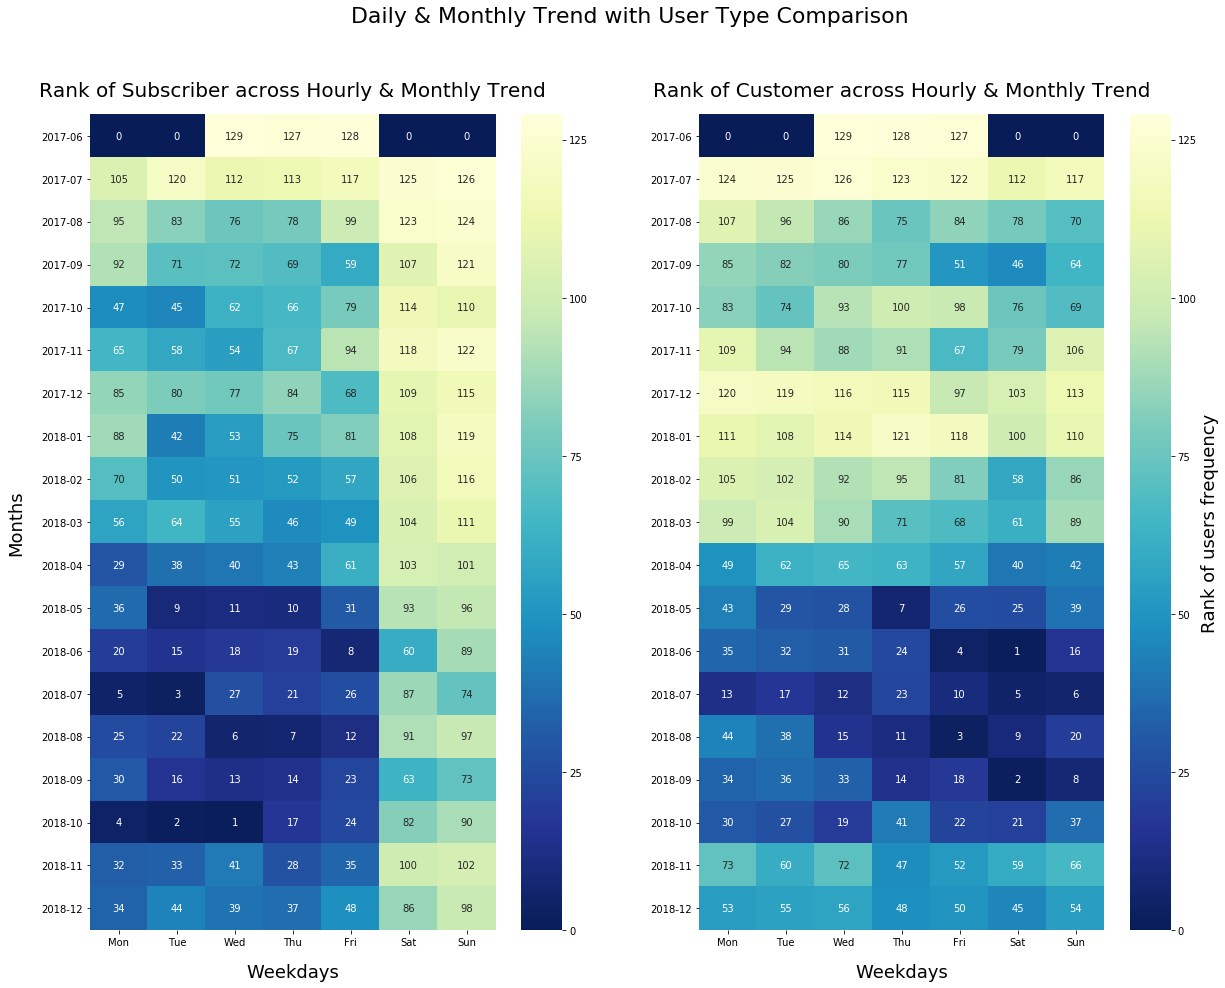

In [138]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.suptitle('Daily & Monthly Trend with User Type Comparison', fontsize=22)
sb.heatmap(subs_md_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r',annot_kws={"size": 10})
plt.title("Rank of Subscriber across Hourly & Monthly Trend", fontsize=20, y=1.015)
plt.xlabel('Weekdays', fontsize=18, labelpad=16)
plt.ylabel('Months', fontsize=18, labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
ax = sb.heatmap(cust_md_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 10}, cbar_kws={'label': 'Rank of users frequency'})
plt.title("Rank of Customer across Hourly & Monthly Trend", fontsize=20, y=1.015)
plt.xlabel('Weekdays', fontsize=18, labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
ax.figure.axes[-1].set_ylabel('Rank of users frequency', size=18)

This graph only complement the findings that the Subscribers heavily used the bike during weekdays while for customers also use the bike heavily on saturdays and some months for sundays as well 

## Question 
### Question 1: Which timing of the following rides is busiest during the days, months and hours? 

We will delve into which time of the days, months and hours is the most crowded and the reason for the trends

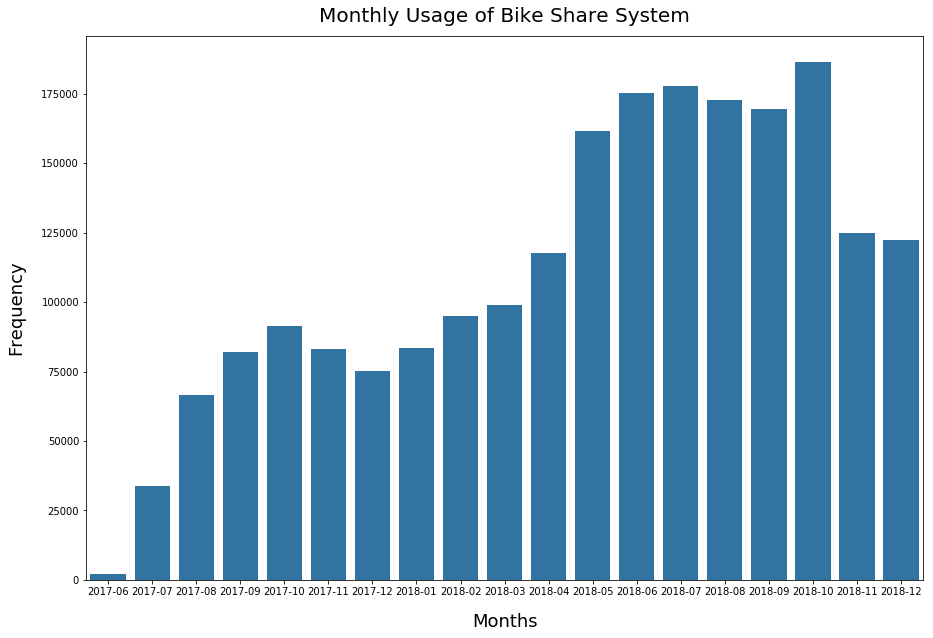

In [176]:
plt.figure(figsize=(15,10))
sb.barplot(data=ym_df, x='start_time_year_month', y='count', color = base_color)
plt.title("Monthly Usage of Bike Share System", fontsize=20, y=1.015)
plt.xlabel('Months', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Monthly Usage of Bike Share System.png')

For monthly trend, we can see a pattern: There are increasing trends for each month with slight down trend for the November and December. The reason might be the weather as well as holidays 

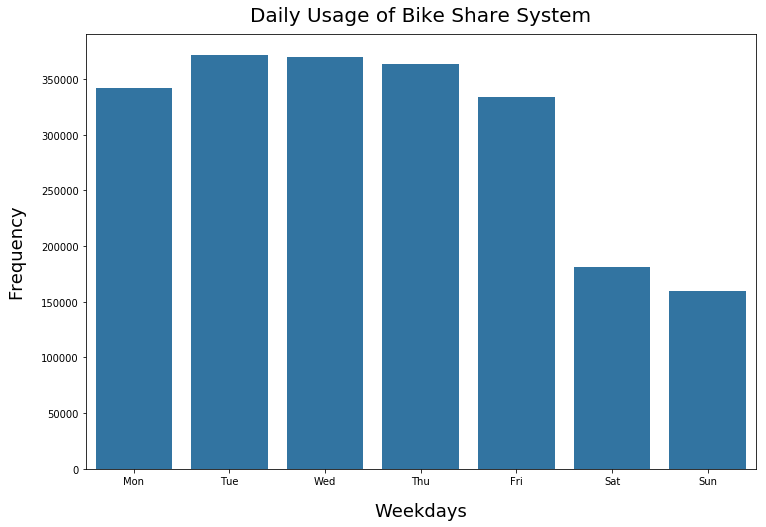

In [177]:
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(12,8))
sb.barplot(data=days_df, x='start_time_weekday_abbr', y='count', color = base_color, order= weekday)
plt.title("Daily Usage of Bike Share System", fontsize=20, y=1.015)
plt.xlabel('Weekdays', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Daily Usage of Bike Share System.png')

for the weekdays, The busiest time is Tuesday followed by Wednesday while the day with the least traffic is weekends (Saturday and Sunday) 

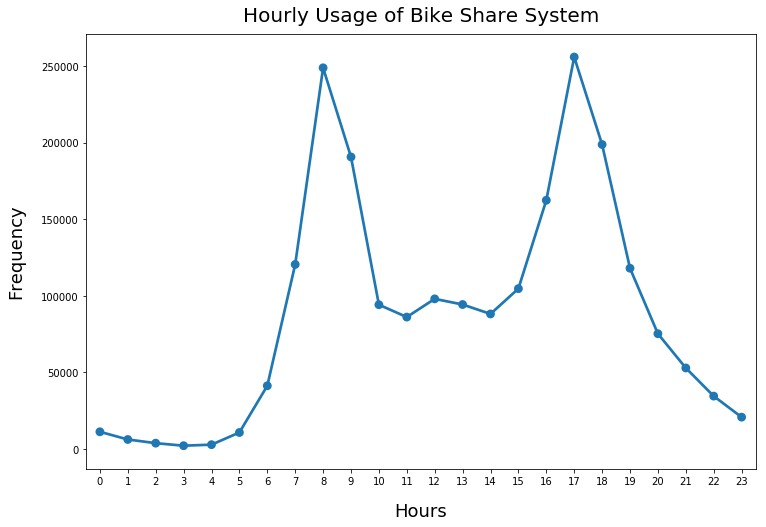

In [178]:
plt.figure(figsize=(12,8))
sb.pointplot(data=hour_df, x='start_time_hour', y='count', color = base_color)
plt.title("Hourly Usage of Bike Share System", fontsize=20, y=1.015)
plt.xlabel('Hours', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Hourly Usage of Bike Share System.png')

for the hours, the busiest hours are 8am and 5pm, the time where people going to work

### Question 2: How does the duration trip trend look like? 

By knowing the duration trend of the trips, we can get insight and set benchmark for the next questions

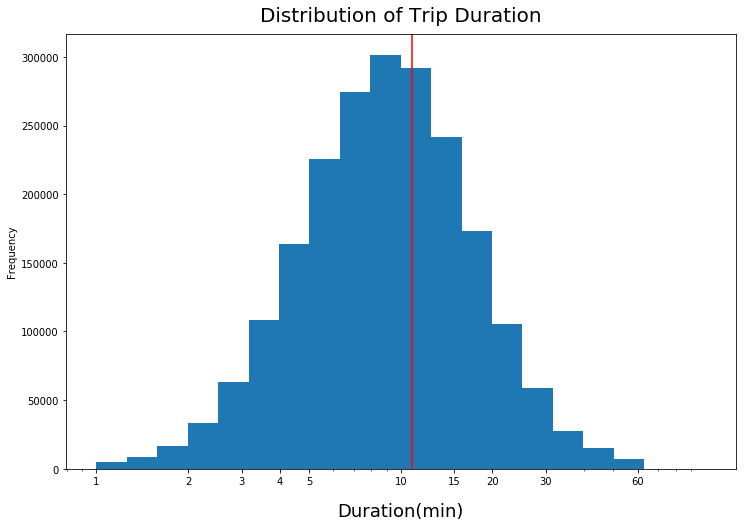

In [179]:
plt.figure(figsize=(12,8))
bins = 10**np.arange(0 , 2+0.1 , 0.1)
ticks =  [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df5 , x = 'duration_min' , bins = bins);
plt.xlabel('Duration(min)', fontsize=18, labelpad=16)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.title('Distribution of Trip Duration', fontsize=20, y=1.015)
plt.ylabel('Frequency')
plt.axvline(x=df5['duration_min'].mean(), color='red')
plt.savefig('Distribution of Trip Duration.png')

The average duration of the trip is 10.8 minutes with the limitation of 60 minutes of each trip set by the Ford Go Bike 

### Question 3: Is there any particular effect of the operational area? 

After we filtered the rides according to their respective areas, we would like to see whether there is any new insights or trends by adding the area variable 

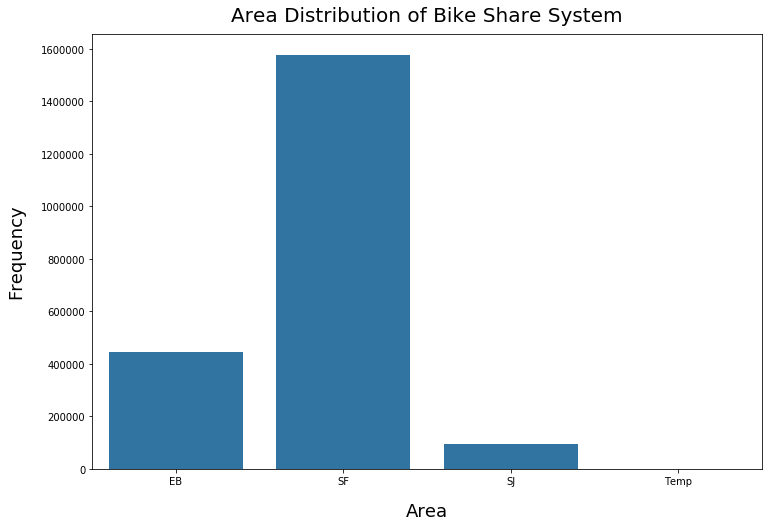

In [180]:
plt.figure(figsize=(12,8))
sb.barplot(data=area_df, x='area', y='count', color = base_color)
plt.title('Area Distribution of Bike Share System', fontsize=20, y=1.015)
plt.xlabel('Area', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Area Distribution of Bike Share System.png')

The area with the most bike share usage is the San Fransisco (SF) followed by East Bay (EB), San Jose (SJ) and then temporary station (Temp) 

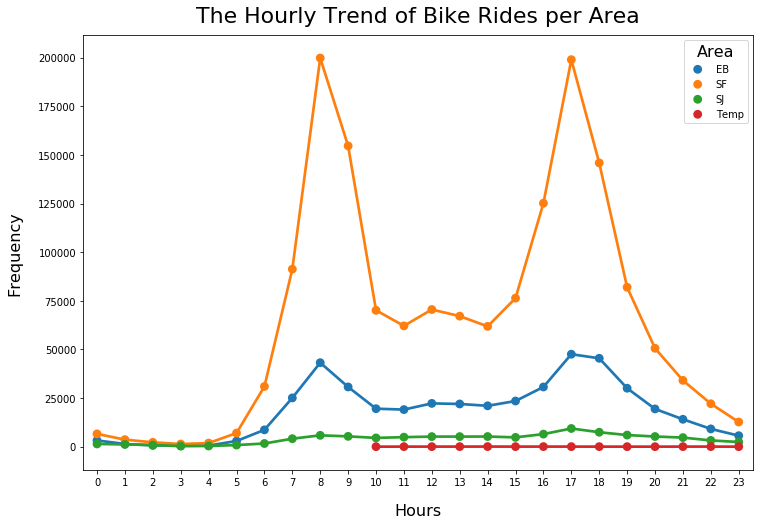

In [194]:
plt.figure(figsize=(12,8))
ax = sb.pointplot(x='start_time_hour', y=0, hue='area', data=area_count_df)
plt.title('The Hourly Trend of Bike Rides per Area', fontsize=22, y=1.015)
plt.xlabel('Hours', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.savefig('The Hourly Trend of Bike Rides per Area')

We found out that the operational hours for the temporary stations only from 10am until 11pm and also all of the areas except the temporary stations have the same trend as previous hours graphs where 8am and 5pm is the most crowded; however, the effect for each areas have slight differences: 
1. San Fransisco with the most fluctuative one with 8am and 5pm as its center 
2. East Bay almost the same trend with San Fransisco except of 6pm also crowded 
3. San Jose have the least fluctuation and almost have the same line throughout the graph; however, we can see that there is some similarities with its previous two station trends 

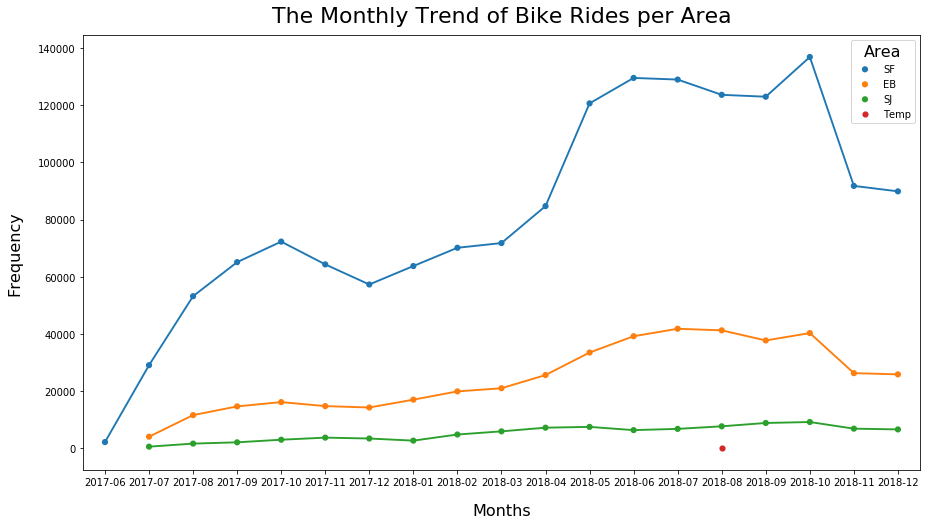

In [184]:
plt.figure(figsize=(15,8))
ax = sb.pointplot(x='start_time_year_month', y=0, hue='area', data=area_count_df2)
plt.title('The Monthly Trend of Bike Rides per Area', fontsize=22, y=1.015)
plt.xlabel('Months', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.savefig('The Monthly Trend of Bike Rides per Area')

The trend for the temporary station is only operational at August 2018 and San Fransisco station is the only one available at June 2017. The trend is the same as previous graph of monthly trend where all areas (except temporary) have the trend of rising with certain downtrend point for November and December. 

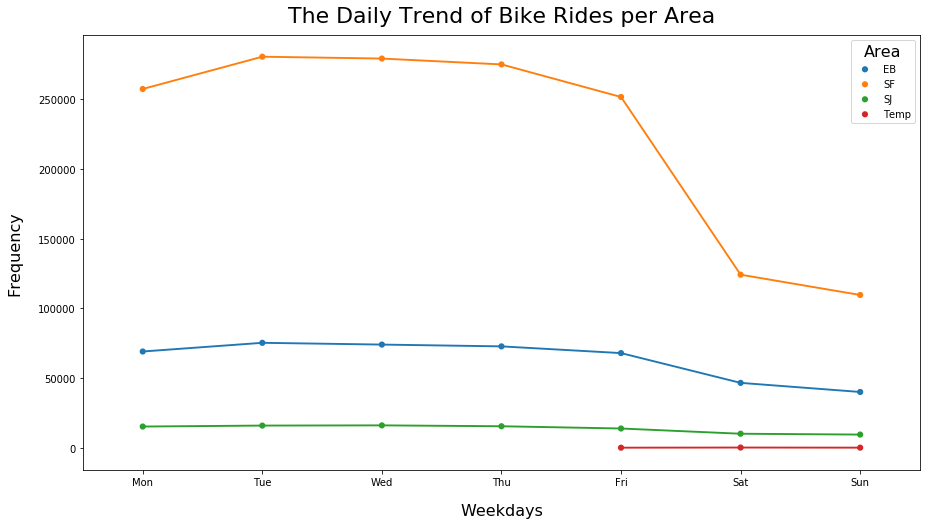

In [186]:
plt.figure(figsize=(15,8))
dayorder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sb.pointplot(x='start_time_weekday_abbr', y=0, hue='area', data=area_count_df3, order=dayorder)
plt.title('The Daily Trend of Bike Rides per Area', fontsize=22)
plt.xlabel('Weekdays', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('Area',prop={'size':16})
plt.savefig('The Daily Trend of Bike Rides per Area')

Once again we find out that temporary station only operational at Friday-Sunday. All of the remaining areas follow the same trend: the weekdays have more usage than weekends

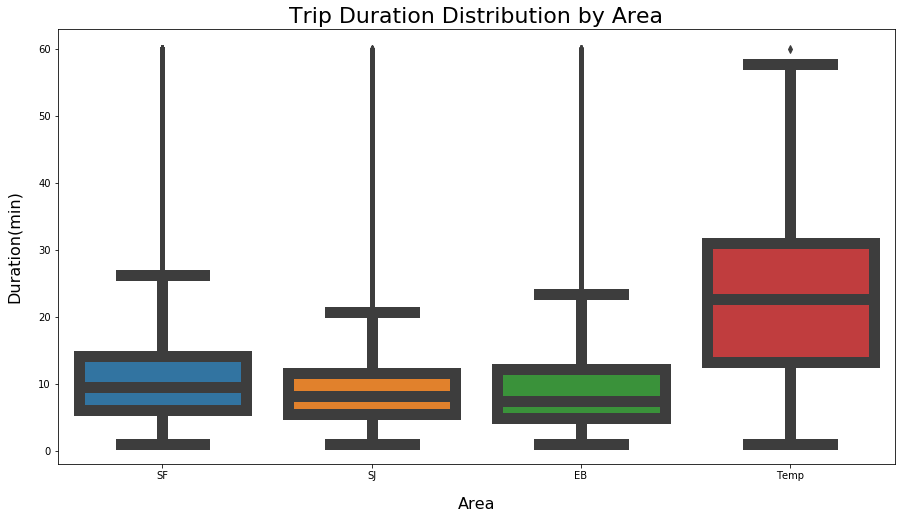

In [188]:
plt.figure(figsize=(15,8))
ax = sb.boxplot(x='area', y='duration_min', linewidth=11, data= df5)
plt.title('Trip Duration Distribution by Area', fontsize=22)
plt.xlabel('Area', fontsize=16, labelpad=16)
plt.ylabel('Duration(min)', fontsize=16, labelpad=16)
plt.savefig('Trip Duration Distribution by Area')

The duration of the trips for each area are almost the same except the temporary station where the number of available stations are limited 

### Question 4: What are the differences between subscriber and normal customer from their trends?

We will uncover deeper with user type variables added to the trends of daily, hourly, monthly and durations

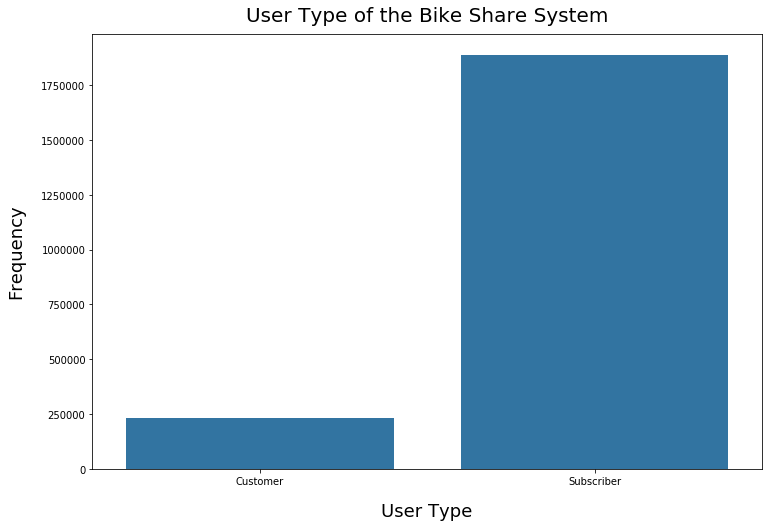

In [189]:
plt.figure(figsize=(12,8))
sb.barplot(data=user_df, x='user_type', y='count', color = base_color)
plt.title("User Type of the Bike Share System", fontsize=20, y=1.015)
plt.xlabel('User Type', fontsize=18, labelpad=16)
plt.ylabel('Frequency', fontsize=18, labelpad=16)
plt.savefig('Trip Duration Distribution by Area')

The subscriber have almost 6x the amount of the non-subscriber customer which makes sense because the benefit for the frequent usage is higher for subscriber who paid for fixed amount rather than the non-subscriber customer who have to pay every time they use the bike 

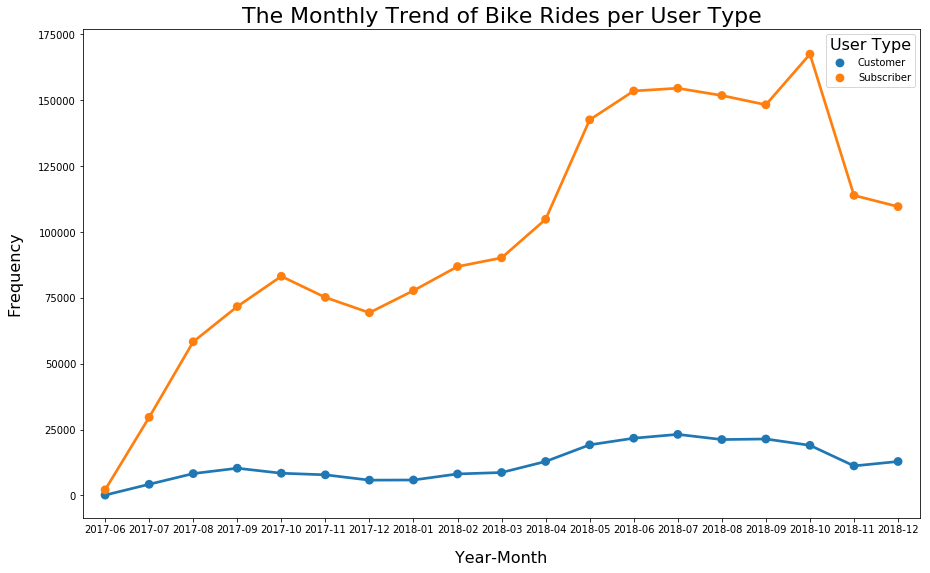

In [190]:
plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_time_year_month', y=0, hue='user_type', data=user_type_count_df)
plt.title('The Monthly Trend of Bike Rides per User Type', fontsize=22)
plt.xlabel('Year-Month', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
plt.savefig('The Monthly Trend of Bike Rides per User Type')

The monthly trend for each user type is actually similar: the rising trend for the months until the down trends in November and December. 

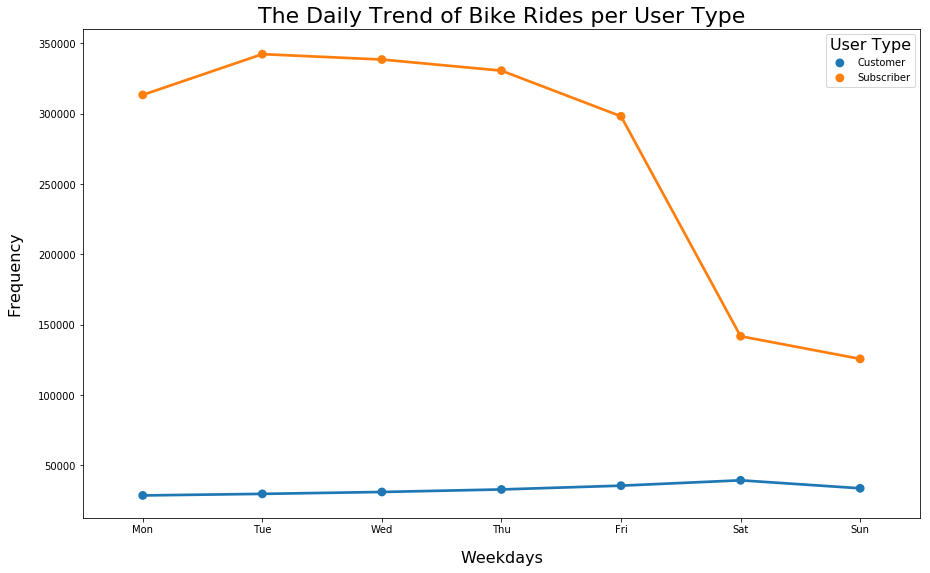

In [191]:
plt.figure(figsize=(15,9))
dayorder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sb.pointplot(x='start_time_weekday_abbr', y=0, hue='user_type', data=user_type_count_df2, order= dayorder)
plt.title('The Daily Trend of Bike Rides per User Type', fontsize=22)
plt.xlabel('Weekdays', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
plt.savefig('The Daily Trend of Bike Rides per User Type')

There is additional information for the non-subscriber customers: they used the bike more during weekends especially Saturday while subscriber used it heavily on weekdays or working days. 

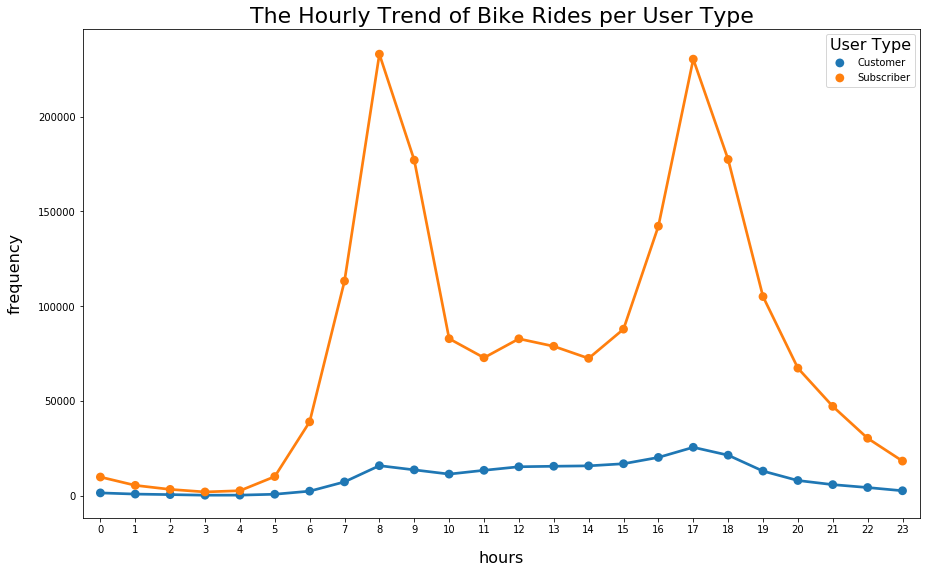

In [195]:
plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_time_hour', y=0, hue='user_type', data=user_type_count_df3)
plt.title('The Hourly Trend of Bike Rides per User Type', fontsize=22)
plt.xlabel('Hours', fontsize=16, labelpad=16)
plt.ylabel('Frequency', fontsize=16, labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
plt.savefig('The Hourly Trend of Bike Rides per User Type')

There is differences for customer and subscriber which is the customer type usage appear to be more disperse compared to subscriber type usage which is more centered toward 8am and 5pm  

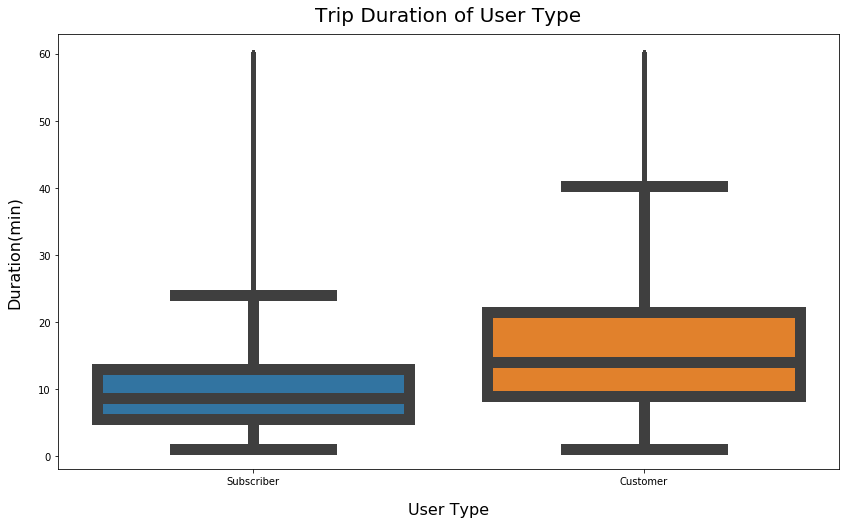

In [196]:
plt.figure(figsize=(14,8))
ax = sb.boxplot(x='user_type', y='duration_min', linewidth=11, data= df5)
plt.title('Trip Duration of User Type', fontsize=20, y=1.015)
plt.xlabel('User Type', fontsize=16, labelpad=16)
plt.ylabel('Duration(min)', fontsize=16, labelpad=16)
plt.savefig('Trip Duration of User Type')

The duration trip for the customer is averagely longer than subscriber. Customer also have higher maximum value which indicate that customer duratio trip is more disperse compared to subscriber duration trip.

## Conclusion 

After filtering the data of the Ford Go Bike ride from 2017-2018 and answering the questions, we find out that the primary usage of the Ford Go Bike is the go-to-work transportation which is proven by the weekdays usage is higher than weekend usage individually and the most crowded hours are 8am and 5pm (going to work and going home time). The usage downtrend of December 2017 and 2018 also might be caused by the holiday season which reduced the number of worker going to work. From the number of subscriber, we can also indicate that many who rides the bike daily are workers. This can be proven by the fact which the subscriber ride is heavily leaned toward working days rather than weekends as well as the fact that subscriber busy hours are 8am and 5pm which fit the profile for worker profile. 

For people who wanted to know the crowdest moment so they can rent a bike successfully, they can avoid the weekdays 8am and 5pm as well as renting it during holidays month like December. For the operational areas, San Fransisco is the one with the most ride while both East Bay and San Jose are less crowded (though might still be better to avoid 8am and 5pm weekdays in both areas as well as 6pm in East Bay weekdays) 